In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2369984, 828)
(2369984, 8)
validation
(319720, 828)
(319720, 8)
test
(302848, 828)
(302848, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/237 [..............................] - ETA: 4:48 - loss: 2.3577 - STD: 0.0894 - MAE: 0.2185

  5/237 [..............................] - ETA: 3s - loss: 2.1394 - STD: 0.0515 - MAE: 0.2171  

  9/237 [>.............................] - ETA: 3s - loss: 2.1171 - STD: 0.0512 - MAE: 0.2167

 13/237 [>.............................] - ETA: 3s - loss: 2.1018 - STD: 0.0496 - MAE: 0.2165

 17/237 [=>............................] - ETA: 3s - loss: 2.0905 - STD: 0.0454 - MAE: 0.2166

 21/237 [=>............................] - ETA: 3s - loss: 2.0846 - STD: 0.0422 - MAE: 0.2167

 25/237 [==>...........................] - ETA: 3s - loss: 2.0795 - STD: 0.0405 - MAE: 0.2167

 29/237 [==>...........................] - ETA: 3s - loss: 2.0751 - STD: 0.0396 - MAE: 0.2167

 33/237 [===>..........................] - ETA: 3s - loss: 2.0715 - STD: 0.0390 - MAE: 0.2166

 37/237 [===>..........................] - ETA: 3s - loss: 2.0678 - STD: 0.0389 - MAE: 0.2165

 41/237 [====>.........................] - ETA: 3s - loss: 2.0638 - STD: 0.0383 - MAE: 0.2164

 45/237 [====>.........................] - ETA: 3s - loss: 2.0589 - STD: 0.0381 - MAE: 0.2163

 49/237 [=====>........................] - ETA: 2s - loss: 2.0527 - STD: 0.0383 - MAE: 0.2161

 53/237 [=====>........................] - ETA: 2s - loss: 2.0448 - STD: 0.0392 - MAE: 0.2158

 57/237 [======>.......................] - ETA: 2s - loss: 2.0362 - STD: 0.0406 - MAE: 0.2153

 61/237 [======>.......................] - ETA: 2s - loss: 2.0274 - STD: 0.0424 - MAE: 0.2149

 65/237 [=======>......................] - ETA: 2s - loss: 2.0184 - STD: 0.0440 - MAE: 0.2144

 69/237 [=======>......................] - ETA: 2s - loss: 2.0091 - STD: 0.0458 - MAE: 0.2139

 73/237 [========>.....................] - ETA: 2s - loss: 1.9996 - STD: 0.0476 - MAE: 0.2134

 77/237 [========>.....................] - ETA: 2s - loss: 1.9893 - STD: 0.0493 - MAE: 0.2129

 81/237 [=========>....................] - ETA: 2s - loss: 1.9782 - STD: 0.0511 - MAE: 0.2123

 85/237 [=========>....................] - ETA: 2s - loss: 1.9653 - STD: 0.0529 - MAE: 0.2116

 89/237 [==========>...................] - ETA: 2s - loss: 1.9505 - STD: 0.0549 - MAE: 0.2108

 93/237 [==========>...................] - ETA: 2s - loss: 1.9346 - STD: 0.0572 - MAE: 0.2099

 97/237 [===========>..................] - ETA: 2s - loss: 1.9184 - STD: 0.0596 - MAE: 0.2089

100/237 [===========>..................] - ETA: 3s - loss: 1.9064 - STD: 0.0615 - MAE: 0.2081

104/237 [============>.................] - ETA: 2s - loss: 1.8903 - STD: 0.0640 - MAE: 0.2071

108/237 [============>.................] - ETA: 2s - loss: 1.8745 - STD: 0.0665 - MAE: 0.2061

112/237 [=============>................] - ETA: 2s - loss: 1.8594 - STD: 0.0690 - MAE: 0.2050

116/237 [=============>................] - ETA: 2s - loss: 1.8449 - STD: 0.0714 - MAE: 0.2040

120/237 [==============>...............] - ETA: 2s - loss: 1.8306 - STD: 0.0738 - MAE: 0.2030

124/237 [==============>...............] - ETA: 2s - loss: 1.8170 - STD: 0.0761 - MAE: 0.2020

128/237 [===============>..............] - ETA: 2s - loss: 1.8037 - STD: 0.0784 - MAE: 0.2011

132/237 [===============>..............] - ETA: 2s - loss: 1.7909 - STD: 0.0806 - MAE: 0.2001

136/237 [================>.............] - ETA: 2s - loss: 1.7787 - STD: 0.0827 - MAE: 0.1992

140/237 [================>.............] - ETA: 1s - loss: 1.7669 - STD: 0.0847 - MAE: 0.1983

144/237 [=================>............] - ETA: 1s - loss: 1.7555 - STD: 0.0867 - MAE: 0.1975

148/237 [=================>............] - ETA: 1s - loss: 1.7444 - STD: 0.0886 - MAE: 0.1966

152/237 [==================>...........] - ETA: 1s - loss: 1.7340 - STD: 0.0904 - MAE: 0.1958

156/237 [==================>...........] - ETA: 1s - loss: 1.7238 - STD: 0.0921 - MAE: 0.1950

160/237 [===================>..........] - ETA: 1s - loss: 1.7140 - STD: 0.0938 - MAE: 0.1943

164/237 [===================>..........] - ETA: 1s - loss: 1.7047 - STD: 0.0954 - MAE: 0.1936

168/237 [====================>.........] - ETA: 1s - loss: 1.6954 - STD: 0.0970 - MAE: 0.1929

172/237 [====================>.........] - ETA: 1s - loss: 1.6865 - STD: 0.0985 - MAE: 0.1922

176/237 [=====================>........] - ETA: 1s - loss: 1.6779 - STD: 0.1001 - MAE: 0.1915

180/237 [=====================>........] - ETA: 1s - loss: 1.6693 - STD: 0.1015 - MAE: 0.1908

184/237 [======================>.......] - ETA: 1s - loss: 1.6611 - STD: 0.1028 - MAE: 0.1902

188/237 [======================>.......] - ETA: 0s - loss: 1.6529 - STD: 0.1042 - MAE: 0.1895

192/237 [=======================>......] - ETA: 0s - loss: 1.6452 - STD: 0.1055 - MAE: 0.1889

193/237 [=======================>......] - ETA: 0s - loss: 1.6433 - STD: 0.1058 - MAE: 0.1888

197/237 [=======================>......] - ETA: 0s - loss: 1.6360 - STD: 0.1071 - MAE: 0.1882

201/237 [========================>.....] - ETA: 0s - loss: 1.6287 - STD: 0.1083 - MAE: 0.1876

205/237 [========================>.....] - ETA: 0s - loss: 1.6216 - STD: 0.1095 - MAE: 0.1871

209/237 [=========================>....] - ETA: 0s - loss: 1.6147 - STD: 0.1107 - MAE: 0.1865

213/237 [=========================>....] - ETA: 0s - loss: 1.6080 - STD: 0.1118 - MAE: 0.1860

217/237 [==========================>...] - ETA: 0s - loss: 1.6017 - STD: 0.1129 - MAE: 0.1854

221/237 [==========================>...] - ETA: 0s - loss: 1.5955 - STD: 0.1140 - MAE: 0.1849

225/237 [===========================>..] - ETA: 0s - loss: 1.5893 - STD: 0.1150 - MAE: 0.1844

229/237 [===========================>..] - ETA: 0s - loss: 1.5832 - STD: 0.1161 - MAE: 0.1839

233/237 [============================>.] - ETA: 0s - loss: 1.5772 - STD: 0.1170 - MAE: 0.1835

237/237 [==============================] - ETA: 0s - loss: 1.5714 - STD: 0.1180 - MAE: 0.1830

237/237 [==============================] - 7s 23ms/step - loss: 1.5714 - STD: 0.1180 - MAE: 0.1830 - val_loss: 1.3281 - val_STD: 0.1700 - val_MAE: 0.1607


Epoch 2/10000


  1/237 [..............................] - ETA: 10s - loss: 1.2354 - STD: 0.1746 - MAE: 0.1556

  5/237 [..............................] - ETA: 3s - loss: 1.2319 - STD: 0.1741 - MAE: 0.1556 

  9/237 [>.............................] - ETA: 3s - loss: 1.2328 - STD: 0.1747 - MAE: 0.1555

 13/237 [>.............................] - ETA: 3s - loss: 1.2316 - STD: 0.1754 - MAE: 0.1552

 17/237 [=>............................] - ETA: 3s - loss: 1.2283 - STD: 0.1757 - MAE: 0.1549

 21/237 [=>............................] - ETA: 3s - loss: 1.2256 - STD: 0.1762 - MAE: 0.1546

 25/237 [==>...........................] - ETA: 3s - loss: 1.2250 - STD: 0.1765 - MAE: 0.1545

 29/237 [==>...........................] - ETA: 3s - loss: 1.2246 - STD: 0.1767 - MAE: 0.1544

 33/237 [===>..........................] - ETA: 3s - loss: 1.2249 - STD: 0.1769 - MAE: 0.1544

 37/237 [===>..........................] - ETA: 3s - loss: 1.2239 - STD: 0.1769 - MAE: 0.1544

 41/237 [====>.........................] - ETA: 3s - loss: 1.2225 - STD: 0.1770 - MAE: 0.1543

 45/237 [====>.........................] - ETA: 3s - loss: 1.2208 - STD: 0.1771 - MAE: 0.1542

 48/237 [=====>........................] - ETA: 2s - loss: 1.2199 - STD: 0.1772 - MAE: 0.1541

 52/237 [=====>........................] - ETA: 2s - loss: 1.2192 - STD: 0.1773 - MAE: 0.1540

 56/237 [======>.......................] - ETA: 2s - loss: 1.2188 - STD: 0.1774 - MAE: 0.1540

 60/237 [======>.......................] - ETA: 2s - loss: 1.2186 - STD: 0.1776 - MAE: 0.1539

 64/237 [=======>......................] - ETA: 2s - loss: 1.2171 - STD: 0.1778 - MAE: 0.1538

 68/237 [=======>......................] - ETA: 2s - loss: 1.2158 - STD: 0.1780 - MAE: 0.1537

 72/237 [========>.....................] - ETA: 2s - loss: 1.2151 - STD: 0.1781 - MAE: 0.1536

 76/237 [========>.....................] - ETA: 2s - loss: 1.2135 - STD: 0.1783 - MAE: 0.1534

 80/237 [=========>....................] - ETA: 2s - loss: 1.2124 - STD: 0.1784 - MAE: 0.1533

 84/237 [=========>....................] - ETA: 2s - loss: 1.2110 - STD: 0.1786 - MAE: 0.1532

 88/237 [==========>...................] - ETA: 2s - loss: 1.2097 - STD: 0.1787 - MAE: 0.1531

 92/237 [==========>...................] - ETA: 2s - loss: 1.2083 - STD: 0.1788 - MAE: 0.1530

 96/237 [===========>..................] - ETA: 2s - loss: 1.2067 - STD: 0.1790 - MAE: 0.1529

100/237 [===========>..................] - ETA: 2s - loss: 1.2055 - STD: 0.1791 - MAE: 0.1528

104/237 [============>.................] - ETA: 2s - loss: 1.2042 - STD: 0.1793 - MAE: 0.1527

108/237 [============>.................] - ETA: 2s - loss: 1.2027 - STD: 0.1794 - MAE: 0.1525

112/237 [=============>................] - ETA: 1s - loss: 1.2025 - STD: 0.1795 - MAE: 0.1525

116/237 [=============>................] - ETA: 1s - loss: 1.2011 - STD: 0.1797 - MAE: 0.1524

120/237 [==============>...............] - ETA: 1s - loss: 1.1997 - STD: 0.1799 - MAE: 0.1522

124/237 [==============>...............] - ETA: 1s - loss: 1.1985 - STD: 0.1800 - MAE: 0.1521

128/237 [===============>..............] - ETA: 1s - loss: 1.1972 - STD: 0.1802 - MAE: 0.1520

132/237 [===============>..............] - ETA: 1s - loss: 1.1960 - STD: 0.1803 - MAE: 0.1519

136/237 [================>.............] - ETA: 1s - loss: 1.1949 - STD: 0.1804 - MAE: 0.1518

140/237 [================>.............] - ETA: 1s - loss: 1.1935 - STD: 0.1806 - MAE: 0.1517

144/237 [=================>............] - ETA: 1s - loss: 1.1921 - STD: 0.1807 - MAE: 0.1515

148/237 [=================>............] - ETA: 1s - loss: 1.1909 - STD: 0.1809 - MAE: 0.1514

152/237 [==================>...........] - ETA: 1s - loss: 1.1900 - STD: 0.1811 - MAE: 0.1513

156/237 [==================>...........] - ETA: 1s - loss: 1.1893 - STD: 0.1812 - MAE: 0.1512

160/237 [===================>..........] - ETA: 1s - loss: 1.1884 - STD: 0.1814 - MAE: 0.1511

164/237 [===================>..........] - ETA: 1s - loss: 1.1871 - STD: 0.1815 - MAE: 0.1510

168/237 [====================>.........] - ETA: 1s - loss: 1.1865 - STD: 0.1817 - MAE: 0.1509

172/237 [====================>.........] - ETA: 1s - loss: 1.1857 - STD: 0.1818 - MAE: 0.1508

176/237 [=====================>........] - ETA: 0s - loss: 1.1846 - STD: 0.1819 - MAE: 0.1507

180/237 [=====================>........] - ETA: 0s - loss: 1.1835 - STD: 0.1820 - MAE: 0.1507

184/237 [======================>.......] - ETA: 0s - loss: 1.1823 - STD: 0.1822 - MAE: 0.1505

188/237 [======================>.......] - ETA: 0s - loss: 1.1810 - STD: 0.1823 - MAE: 0.1504

192/237 [=======================>......] - ETA: 0s - loss: 1.1798 - STD: 0.1825 - MAE: 0.1503

196/237 [=======================>......] - ETA: 0s - loss: 1.1789 - STD: 0.1826 - MAE: 0.1502

200/237 [========================>.....] - ETA: 0s - loss: 1.1777 - STD: 0.1827 - MAE: 0.1501

204/237 [========================>.....] - ETA: 0s - loss: 1.1767 - STD: 0.1829 - MAE: 0.1500

208/237 [=========================>....] - ETA: 0s - loss: 1.1755 - STD: 0.1830 - MAE: 0.1499

212/237 [=========================>....] - ETA: 0s - loss: 1.1745 - STD: 0.1831 - MAE: 0.1498

216/237 [==========================>...] - ETA: 0s - loss: 1.1736 - STD: 0.1833 - MAE: 0.1497

220/237 [==========================>...] - ETA: 0s - loss: 1.1728 - STD: 0.1834 - MAE: 0.1496

224/237 [===========================>..] - ETA: 0s - loss: 1.1720 - STD: 0.1835 - MAE: 0.1495

228/237 [===========================>..] - ETA: 0s - loss: 1.1709 - STD: 0.1836 - MAE: 0.1494

232/237 [============================>.] - ETA: 0s - loss: 1.1699 - STD: 0.1838 - MAE: 0.1493

236/237 [============================>.] - ETA: 0s - loss: 1.1689 - STD: 0.1839 - MAE: 0.1492

237/237 [==============================] - 4s 17ms/step - loss: 1.1688 - STD: 0.1840 - MAE: 0.1492 - val_loss: 1.2926 - val_STD: 0.1893 - val_MAE: 0.1526


Epoch 3/10000


  1/237 [..............................] - ETA: 11s - loss: 1.1116 - STD: 0.1928 - MAE: 0.1429

  4/237 [..............................] - ETA: 4s - loss: 1.1142 - STD: 0.1929 - MAE: 0.1431 

  8/237 [>.............................] - ETA: 3s - loss: 1.1108 - STD: 0.1925 - MAE: 0.1430

 12/237 [>.............................] - ETA: 3s - loss: 1.1125 - STD: 0.1923 - MAE: 0.1432

 16/237 [=>............................] - ETA: 3s - loss: 1.1116 - STD: 0.1924 - MAE: 0.1431

 20/237 [=>............................] - ETA: 3s - loss: 1.1087 - STD: 0.1924 - MAE: 0.1430

 24/237 [==>...........................] - ETA: 3s - loss: 1.1069 - STD: 0.1925 - MAE: 0.1428

 28/237 [==>...........................] - ETA: 3s - loss: 1.1052 - STD: 0.1926 - MAE: 0.1427

 32/237 [===>..........................] - ETA: 3s - loss: 1.1040 - STD: 0.1927 - MAE: 0.1426

 36/237 [===>..........................] - ETA: 3s - loss: 1.1035 - STD: 0.1928 - MAE: 0.1426

 39/237 [===>..........................] - ETA: 3s - loss: 1.1025 - STD: 0.1929 - MAE: 0.1425

 43/237 [====>.........................] - ETA: 3s - loss: 1.1021 - STD: 0.1930 - MAE: 0.1424

 47/237 [====>.........................] - ETA: 2s - loss: 1.1040 - STD: 0.1931 - MAE: 0.1424

 51/237 [=====>........................] - ETA: 2s - loss: 1.1049 - STD: 0.1933 - MAE: 0.1424

 55/237 [=====>........................] - ETA: 2s - loss: 1.1064 - STD: 0.1934 - MAE: 0.1425

 59/237 [======>.......................] - ETA: 2s - loss: 1.1073 - STD: 0.1934 - MAE: 0.1425

 63/237 [======>.......................] - ETA: 2s - loss: 1.1077 - STD: 0.1934 - MAE: 0.1425

 67/237 [=======>......................] - ETA: 2s - loss: 1.1078 - STD: 0.1935 - MAE: 0.1425

 71/237 [=======>......................] - ETA: 2s - loss: 1.1074 - STD: 0.1936 - MAE: 0.1424

 75/237 [========>.....................] - ETA: 2s - loss: 1.1069 - STD: 0.1936 - MAE: 0.1424

 79/237 [=========>....................] - ETA: 2s - loss: 1.1057 - STD: 0.1936 - MAE: 0.1423

 83/237 [=========>....................] - ETA: 2s - loss: 1.1047 - STD: 0.1936 - MAE: 0.1423

 87/237 [==========>...................] - ETA: 2s - loss: 1.1037 - STD: 0.1937 - MAE: 0.1422

 91/237 [==========>...................] - ETA: 2s - loss: 1.1028 - STD: 0.1938 - MAE: 0.1421

 95/237 [===========>..................] - ETA: 2s - loss: 1.1015 - STD: 0.1938 - MAE: 0.1420

 99/237 [===========>..................] - ETA: 2s - loss: 1.1003 - STD: 0.1939 - MAE: 0.1419

103/237 [============>.................] - ETA: 2s - loss: 1.0995 - STD: 0.1941 - MAE: 0.1418

107/237 [============>.................] - ETA: 2s - loss: 1.0991 - STD: 0.1941 - MAE: 0.1418

111/237 [=============>................] - ETA: 1s - loss: 1.0984 - STD: 0.1942 - MAE: 0.1417

115/237 [=============>................] - ETA: 1s - loss: 1.0973 - STD: 0.1943 - MAE: 0.1416

119/237 [==============>...............] - ETA: 1s - loss: 1.0966 - STD: 0.1944 - MAE: 0.1416

123/237 [==============>...............] - ETA: 1s - loss: 1.0957 - STD: 0.1945 - MAE: 0.1415

127/237 [===============>..............] - ETA: 1s - loss: 1.0948 - STD: 0.1946 - MAE: 0.1414

131/237 [===============>..............] - ETA: 1s - loss: 1.0941 - STD: 0.1947 - MAE: 0.1413

135/237 [================>.............] - ETA: 1s - loss: 1.0936 - STD: 0.1947 - MAE: 0.1413

139/237 [================>.............] - ETA: 1s - loss: 1.0929 - STD: 0.1948 - MAE: 0.1412

143/237 [=================>............] - ETA: 1s - loss: 1.0920 - STD: 0.1949 - MAE: 0.1411

147/237 [=================>............] - ETA: 1s - loss: 1.0910 - STD: 0.1950 - MAE: 0.1410

151/237 [==================>...........] - ETA: 1s - loss: 1.0901 - STD: 0.1952 - MAE: 0.1409

155/237 [==================>...........] - ETA: 1s - loss: 1.0893 - STD: 0.1952 - MAE: 0.1408

159/237 [===================>..........] - ETA: 1s - loss: 1.0887 - STD: 0.1953 - MAE: 0.1408

163/237 [===================>..........] - ETA: 1s - loss: 1.0879 - STD: 0.1954 - MAE: 0.1407

167/237 [====================>.........] - ETA: 1s - loss: 1.0871 - STD: 0.1955 - MAE: 0.1406

171/237 [====================>.........] - ETA: 1s - loss: 1.0862 - STD: 0.1956 - MAE: 0.1405

175/237 [=====================>........] - ETA: 0s - loss: 1.0854 - STD: 0.1956 - MAE: 0.1405

179/237 [=====================>........] - ETA: 0s - loss: 1.0847 - STD: 0.1957 - MAE: 0.1404

183/237 [======================>.......] - ETA: 0s - loss: 1.0840 - STD: 0.1958 - MAE: 0.1403

187/237 [======================>.......] - ETA: 0s - loss: 1.0833 - STD: 0.1959 - MAE: 0.1403

191/237 [=======================>......] - ETA: 0s - loss: 1.0829 - STD: 0.1960 - MAE: 0.1402

195/237 [=======================>......] - ETA: 0s - loss: 1.0823 - STD: 0.1961 - MAE: 0.1401

199/237 [========================>.....] - ETA: 0s - loss: 1.0817 - STD: 0.1962 - MAE: 0.1401

203/237 [========================>.....] - ETA: 0s - loss: 1.0811 - STD: 0.1963 - MAE: 0.1400

207/237 [=========================>....] - ETA: 0s - loss: 1.0803 - STD: 0.1964 - MAE: 0.1399

211/237 [=========================>....] - ETA: 0s - loss: 1.0797 - STD: 0.1964 - MAE: 0.1398

215/237 [==========================>...] - ETA: 0s - loss: 1.0792 - STD: 0.1965 - MAE: 0.1398

219/237 [==========================>...] - ETA: 0s - loss: 1.0786 - STD: 0.1966 - MAE: 0.1397

223/237 [===========================>..] - ETA: 0s - loss: 1.0779 - STD: 0.1967 - MAE: 0.1396

227/237 [===========================>..] - ETA: 0s - loss: 1.0771 - STD: 0.1968 - MAE: 0.1396

231/237 [============================>.] - ETA: 0s - loss: 1.0764 - STD: 0.1968 - MAE: 0.1395

235/237 [============================>.] - ETA: 0s - loss: 1.0757 - STD: 0.1969 - MAE: 0.1394

237/237 [==============================] - 4s 17ms/step - loss: 1.0753 - STD: 0.1970 - MAE: 0.1394 - val_loss: 1.2306 - val_STD: 0.1998 - val_MAE: 0.1463


Epoch 4/10000


  1/237 [..............................] - ETA: 9s - loss: 1.0367 - STD: 0.2022 - MAE: 0.1351

  5/237 [..............................] - ETA: 3s - loss: 1.0377 - STD: 0.2023 - MAE: 0.1353

  9/237 [>.............................] - ETA: 3s - loss: 1.0495 - STD: 0.2017 - MAE: 0.1362

 13/237 [>.............................] - ETA: 3s - loss: 1.0519 - STD: 0.2019 - MAE: 0.1362

 17/237 [=>............................] - ETA: 3s - loss: 1.0495 - STD: 0.2018 - MAE: 0.1361

 21/237 [=>............................] - ETA: 3s - loss: 1.0473 - STD: 0.2019 - MAE: 0.1359

 25/237 [==>...........................] - ETA: 3s - loss: 1.0437 - STD: 0.2021 - MAE: 0.1357

 29/237 [==>...........................] - ETA: 3s - loss: 1.0405 - STD: 0.2022 - MAE: 0.1354

 32/237 [===>..........................] - ETA: 3s - loss: 1.0386 - STD: 0.2021 - MAE: 0.1353

 36/237 [===>..........................] - ETA: 3s - loss: 1.0376 - STD: 0.2022 - MAE: 0.1353

 40/237 [====>.........................] - ETA: 3s - loss: 1.0354 - STD: 0.2023 - MAE: 0.1351

 43/237 [====>.........................] - ETA: 3s - loss: 1.0347 - STD: 0.2024 - MAE: 0.1350

 47/237 [====>.........................] - ETA: 3s - loss: 1.0334 - STD: 0.2025 - MAE: 0.1349

 51/237 [=====>........................] - ETA: 2s - loss: 1.0330 - STD: 0.2026 - MAE: 0.1348

 55/237 [=====>........................] - ETA: 2s - loss: 1.0322 - STD: 0.2027 - MAE: 0.1348

 59/237 [======>.......................] - ETA: 2s - loss: 1.0308 - STD: 0.2027 - MAE: 0.1347

 63/237 [======>.......................] - ETA: 2s - loss: 1.0298 - STD: 0.2029 - MAE: 0.1346

 67/237 [=======>......................] - ETA: 2s - loss: 1.0295 - STD: 0.2029 - MAE: 0.1345

 71/237 [=======>......................] - ETA: 2s - loss: 1.0296 - STD: 0.2030 - MAE: 0.1345

 75/237 [========>.....................] - ETA: 2s - loss: 1.0312 - STD: 0.2031 - MAE: 0.1345

 79/237 [=========>....................] - ETA: 2s - loss: 1.0312 - STD: 0.2032 - MAE: 0.1345

 83/237 [=========>....................] - ETA: 2s - loss: 1.0305 - STD: 0.2032 - MAE: 0.1344

 87/237 [==========>...................] - ETA: 2s - loss: 1.0296 - STD: 0.2033 - MAE: 0.1344

 91/237 [==========>...................] - ETA: 2s - loss: 1.0286 - STD: 0.2033 - MAE: 0.1343

 95/237 [===========>..................] - ETA: 2s - loss: 1.0280 - STD: 0.2034 - MAE: 0.1342

 99/237 [===========>..................] - ETA: 2s - loss: 1.0271 - STD: 0.2034 - MAE: 0.1342

103/237 [============>.................] - ETA: 2s - loss: 1.0263 - STD: 0.2034 - MAE: 0.1341

107/237 [============>.................] - ETA: 2s - loss: 1.0254 - STD: 0.2035 - MAE: 0.1340

111/237 [=============>................] - ETA: 1s - loss: 1.0245 - STD: 0.2036 - MAE: 0.1339

115/237 [=============>................] - ETA: 1s - loss: 1.0245 - STD: 0.2037 - MAE: 0.1339

119/237 [==============>...............] - ETA: 1s - loss: 1.0239 - STD: 0.2038 - MAE: 0.1338

123/237 [==============>...............] - ETA: 1s - loss: 1.0232 - STD: 0.2039 - MAE: 0.1337

127/237 [===============>..............] - ETA: 1s - loss: 1.0221 - STD: 0.2040 - MAE: 0.1336

131/237 [===============>..............] - ETA: 1s - loss: 1.0212 - STD: 0.2041 - MAE: 0.1336

135/237 [================>.............] - ETA: 1s - loss: 1.0203 - STD: 0.2041 - MAE: 0.1335

139/237 [================>.............] - ETA: 1s - loss: 1.0197 - STD: 0.2042 - MAE: 0.1334

143/237 [=================>............] - ETA: 1s - loss: 1.0197 - STD: 0.2043 - MAE: 0.1334

147/237 [=================>............] - ETA: 1s - loss: 1.0195 - STD: 0.2044 - MAE: 0.1333

150/237 [=================>............] - ETA: 1s - loss: 1.0191 - STD: 0.2045 - MAE: 0.1333

154/237 [==================>...........] - ETA: 1s - loss: 1.0185 - STD: 0.2045 - MAE: 0.1332

158/237 [===================>..........] - ETA: 1s - loss: 1.0178 - STD: 0.2046 - MAE: 0.1331

162/237 [===================>..........] - ETA: 1s - loss: 1.0170 - STD: 0.2047 - MAE: 0.1331

166/237 [====================>.........] - ETA: 1s - loss: 1.0164 - STD: 0.2047 - MAE: 0.1330

170/237 [====================>.........] - ETA: 1s - loss: 1.0158 - STD: 0.2048 - MAE: 0.1329

174/237 [=====================>........] - ETA: 0s - loss: 1.0154 - STD: 0.2049 - MAE: 0.1329

178/237 [=====================>........] - ETA: 0s - loss: 1.0149 - STD: 0.2049 - MAE: 0.1328

182/237 [======================>.......] - ETA: 0s - loss: 1.0143 - STD: 0.2050 - MAE: 0.1328

186/237 [======================>.......] - ETA: 0s - loss: 1.0136 - STD: 0.2051 - MAE: 0.1327

190/237 [=======================>......] - ETA: 0s - loss: 1.0129 - STD: 0.2051 - MAE: 0.1326

194/237 [=======================>......] - ETA: 0s - loss: 1.0124 - STD: 0.2052 - MAE: 0.1326

198/237 [========================>.....] - ETA: 0s - loss: 1.0119 - STD: 0.2053 - MAE: 0.1325

202/237 [========================>.....] - ETA: 0s - loss: 1.0112 - STD: 0.2054 - MAE: 0.1324

206/237 [=========================>....] - ETA: 0s - loss: 1.0104 - STD: 0.2054 - MAE: 0.1324

210/237 [=========================>....] - ETA: 0s - loss: 1.0099 - STD: 0.2055 - MAE: 0.1323

214/237 [==========================>...] - ETA: 0s - loss: 1.0093 - STD: 0.2056 - MAE: 0.1323

218/237 [==========================>...] - ETA: 0s - loss: 1.0086 - STD: 0.2056 - MAE: 0.1322

222/237 [===========================>..] - ETA: 0s - loss: 1.0079 - STD: 0.2057 - MAE: 0.1321

226/237 [===========================>..] - ETA: 0s - loss: 1.0075 - STD: 0.2058 - MAE: 0.1321

230/237 [============================>.] - ETA: 0s - loss: 1.0070 - STD: 0.2059 - MAE: 0.1320

234/237 [============================>.] - ETA: 0s - loss: 1.0062 - STD: 0.2059 - MAE: 0.1319

237/237 [==============================] - 4s 18ms/step - loss: 1.0056 - STD: 0.2060 - MAE: 0.1319 - val_loss: 1.2019 - val_STD: 0.2095 - val_MAE: 0.1410


Epoch 5/10000


  1/237 [..............................] - ETA: 10s - loss: 0.9670 - STD: 0.2109 - MAE: 0.1278

  5/237 [..............................] - ETA: 3s - loss: 0.9718 - STD: 0.2113 - MAE: 0.1278 

  9/237 [>.............................] - ETA: 3s - loss: 0.9744 - STD: 0.2111 - MAE: 0.1280

 13/237 [>.............................] - ETA: 3s - loss: 0.9751 - STD: 0.2109 - MAE: 0.1282

 17/237 [=>............................] - ETA: 3s - loss: 0.9725 - STD: 0.2109 - MAE: 0.1280

 21/237 [=>............................] - ETA: 3s - loss: 0.9712 - STD: 0.2110 - MAE: 0.1278

 25/237 [==>...........................] - ETA: 3s - loss: 0.9725 - STD: 0.2109 - MAE: 0.1280

 29/237 [==>...........................] - ETA: 3s - loss: 0.9729 - STD: 0.2111 - MAE: 0.1279

 33/237 [===>..........................] - ETA: 3s - loss: 0.9738 - STD: 0.2112 - MAE: 0.1279

 37/237 [===>..........................] - ETA: 3s - loss: 0.9737 - STD: 0.2112 - MAE: 0.1279

 41/237 [====>.........................] - ETA: 3s - loss: 0.9735 - STD: 0.2111 - MAE: 0.1279

 45/237 [====>.........................] - ETA: 2s - loss: 0.9728 - STD: 0.2111 - MAE: 0.1279

 49/237 [=====>........................] - ETA: 2s - loss: 0.9717 - STD: 0.2112 - MAE: 0.1278

 53/237 [=====>........................] - ETA: 2s - loss: 0.9711 - STD: 0.2112 - MAE: 0.1278

 57/237 [======>.......................] - ETA: 2s - loss: 0.9704 - STD: 0.2112 - MAE: 0.1277

 61/237 [======>.......................] - ETA: 2s - loss: 0.9692 - STD: 0.2113 - MAE: 0.1276

 65/237 [=======>......................] - ETA: 2s - loss: 0.9687 - STD: 0.2114 - MAE: 0.1275

 69/237 [=======>......................] - ETA: 2s - loss: 0.9688 - STD: 0.2115 - MAE: 0.1275

 73/237 [========>.....................] - ETA: 2s - loss: 0.9686 - STD: 0.2115 - MAE: 0.1275

 77/237 [========>.....................] - ETA: 2s - loss: 0.9678 - STD: 0.2116 - MAE: 0.1274

 81/237 [=========>....................] - ETA: 2s - loss: 0.9671 - STD: 0.2116 - MAE: 0.1273

 85/237 [=========>....................] - ETA: 2s - loss: 0.9666 - STD: 0.2117 - MAE: 0.1273

 89/237 [==========>...................] - ETA: 2s - loss: 0.9653 - STD: 0.2118 - MAE: 0.1272

 93/237 [==========>...................] - ETA: 2s - loss: 0.9644 - STD: 0.2118 - MAE: 0.1271

 97/237 [===========>..................] - ETA: 2s - loss: 0.9634 - STD: 0.2119 - MAE: 0.1270

101/237 [===========>..................] - ETA: 2s - loss: 0.9624 - STD: 0.2120 - MAE: 0.1269

105/237 [============>.................] - ETA: 1s - loss: 0.9619 - STD: 0.2121 - MAE: 0.1268

109/237 [============>.................] - ETA: 1s - loss: 0.9611 - STD: 0.2121 - MAE: 0.1268

113/237 [=============>................] - ETA: 1s - loss: 0.9613 - STD: 0.2121 - MAE: 0.1267

117/237 [=============>................] - ETA: 1s - loss: 0.9607 - STD: 0.2122 - MAE: 0.1267

121/237 [==============>...............] - ETA: 1s - loss: 0.9602 - STD: 0.2123 - MAE: 0.1266

125/237 [==============>...............] - ETA: 1s - loss: 0.9604 - STD: 0.2124 - MAE: 0.1266

129/237 [===============>..............] - ETA: 1s - loss: 0.9600 - STD: 0.2124 - MAE: 0.1265

133/237 [===============>..............] - ETA: 1s - loss: 0.9599 - STD: 0.2125 - MAE: 0.1265

137/237 [================>.............] - ETA: 1s - loss: 0.9597 - STD: 0.2125 - MAE: 0.1265

141/237 [================>.............] - ETA: 1s - loss: 0.9592 - STD: 0.2126 - MAE: 0.1264

145/237 [=================>............] - ETA: 1s - loss: 0.9585 - STD: 0.2126 - MAE: 0.1264

149/237 [=================>............] - ETA: 1s - loss: 0.9578 - STD: 0.2126 - MAE: 0.1263

153/237 [==================>...........] - ETA: 1s - loss: 0.9574 - STD: 0.2127 - MAE: 0.1263

157/237 [==================>...........] - ETA: 1s - loss: 0.9568 - STD: 0.2127 - MAE: 0.1262

161/237 [===================>..........] - ETA: 1s - loss: 0.9562 - STD: 0.2128 - MAE: 0.1262

165/237 [===================>..........] - ETA: 1s - loss: 0.9557 - STD: 0.2128 - MAE: 0.1261

169/237 [====================>.........] - ETA: 1s - loss: 0.9549 - STD: 0.2129 - MAE: 0.1260

173/237 [====================>.........] - ETA: 0s - loss: 0.9545 - STD: 0.2130 - MAE: 0.1260

177/237 [=====================>........] - ETA: 0s - loss: 0.9541 - STD: 0.2130 - MAE: 0.1259

181/237 [=====================>........] - ETA: 0s - loss: 0.9543 - STD: 0.2131 - MAE: 0.1259

185/237 [======================>.......] - ETA: 0s - loss: 0.9540 - STD: 0.2132 - MAE: 0.1258

189/237 [======================>.......] - ETA: 0s - loss: 0.9534 - STD: 0.2132 - MAE: 0.1258

193/237 [=======================>......] - ETA: 0s - loss: 0.9529 - STD: 0.2133 - MAE: 0.1257

197/237 [=======================>......] - ETA: 0s - loss: 0.9524 - STD: 0.2133 - MAE: 0.1257

201/237 [========================>.....] - ETA: 0s - loss: 0.9518 - STD: 0.2134 - MAE: 0.1256

205/237 [========================>.....] - ETA: 0s - loss: 0.9513 - STD: 0.2134 - MAE: 0.1256

209/237 [=========================>....] - ETA: 0s - loss: 0.9508 - STD: 0.2135 - MAE: 0.1255

213/237 [=========================>....] - ETA: 0s - loss: 0.9506 - STD: 0.2136 - MAE: 0.1255

217/237 [==========================>...] - ETA: 0s - loss: 0.9503 - STD: 0.2136 - MAE: 0.1254

221/237 [==========================>...] - ETA: 0s - loss: 0.9498 - STD: 0.2137 - MAE: 0.1254

225/237 [===========================>..] - ETA: 0s - loss: 0.9493 - STD: 0.2138 - MAE: 0.1253

229/237 [===========================>..] - ETA: 0s - loss: 0.9491 - STD: 0.2138 - MAE: 0.1253

233/237 [============================>.] - ETA: 0s - loss: 0.9490 - STD: 0.2139 - MAE: 0.1252

237/237 [==============================] - ETA: 0s - loss: 0.9486 - STD: 0.2139 - MAE: 0.1252

237/237 [==============================] - 4s 17ms/step - loss: 0.9486 - STD: 0.2139 - MAE: 0.1252 - val_loss: 1.1361 - val_STD: 0.2113 - val_MAE: 0.1379


Epoch 6/10000


  1/237 [..............................] - ETA: 9s - loss: 0.9443 - STD: 0.2155 - MAE: 0.1247

  4/237 [..............................] - ETA: 4s - loss: 0.9257 - STD: 0.2172 - MAE: 0.1226

  8/237 [>.............................] - ETA: 4s - loss: 0.9172 - STD: 0.2175 - MAE: 0.1220

 12/237 [>.............................] - ETA: 3s - loss: 0.9161 - STD: 0.2178 - MAE: 0.1217

 16/237 [=>............................] - ETA: 3s - loss: 0.9149 - STD: 0.2176 - MAE: 0.1217

 20/237 [=>............................] - ETA: 3s - loss: 0.9150 - STD: 0.2175 - MAE: 0.1217

 24/237 [==>...........................] - ETA: 3s - loss: 0.9133 - STD: 0.2177 - MAE: 0.1215

 28/237 [==>...........................] - ETA: 3s - loss: 0.9131 - STD: 0.2179 - MAE: 0.1214

 32/237 [===>..........................] - ETA: 3s - loss: 0.9129 - STD: 0.2181 - MAE: 0.1213

 36/237 [===>..........................] - ETA: 3s - loss: 0.9130 - STD: 0.2180 - MAE: 0.1214

 40/237 [====>.........................] - ETA: 3s - loss: 0.9125 - STD: 0.2180 - MAE: 0.1213

 44/237 [====>.........................] - ETA: 3s - loss: 0.9111 - STD: 0.2180 - MAE: 0.1212

 48/237 [=====>........................] - ETA: 2s - loss: 0.9106 - STD: 0.2181 - MAE: 0.1212

 52/237 [=====>........................] - ETA: 2s - loss: 0.9105 - STD: 0.2182 - MAE: 0.1211

 56/237 [======>.......................] - ETA: 2s - loss: 0.9105 - STD: 0.2182 - MAE: 0.1211

 60/237 [======>.......................] - ETA: 2s - loss: 0.9110 - STD: 0.2183 - MAE: 0.1211

 64/237 [=======>......................] - ETA: 2s - loss: 0.9111 - STD: 0.2184 - MAE: 0.1211

 68/237 [=======>......................] - ETA: 2s - loss: 0.9116 - STD: 0.2184 - MAE: 0.1211

 72/237 [========>.....................] - ETA: 2s - loss: 0.9114 - STD: 0.2184 - MAE: 0.1211

 76/237 [========>.....................] - ETA: 2s - loss: 0.9119 - STD: 0.2185 - MAE: 0.1210

 80/237 [=========>....................] - ETA: 2s - loss: 0.9115 - STD: 0.2186 - MAE: 0.1210

 84/237 [=========>....................] - ETA: 2s - loss: 0.9108 - STD: 0.2186 - MAE: 0.1209

 88/237 [==========>...................] - ETA: 2s - loss: 0.9102 - STD: 0.2187 - MAE: 0.1209

 91/237 [==========>...................] - ETA: 2s - loss: 0.9097 - STD: 0.2188 - MAE: 0.1208

 95/237 [===========>..................] - ETA: 2s - loss: 0.9098 - STD: 0.2188 - MAE: 0.1208

 99/237 [===========>..................] - ETA: 2s - loss: 0.9093 - STD: 0.2189 - MAE: 0.1207

103/237 [============>.................] - ETA: 2s - loss: 0.9093 - STD: 0.2189 - MAE: 0.1207

107/237 [============>.................] - ETA: 2s - loss: 0.9091 - STD: 0.2190 - MAE: 0.1207

111/237 [=============>................] - ETA: 1s - loss: 0.9093 - STD: 0.2190 - MAE: 0.1207

115/237 [=============>................] - ETA: 1s - loss: 0.9089 - STD: 0.2191 - MAE: 0.1206

119/237 [==============>...............] - ETA: 1s - loss: 0.9082 - STD: 0.2191 - MAE: 0.1206

123/237 [==============>...............] - ETA: 1s - loss: 0.9077 - STD: 0.2192 - MAE: 0.1205

127/237 [===============>..............] - ETA: 1s - loss: 0.9073 - STD: 0.2192 - MAE: 0.1205

131/237 [===============>..............] - ETA: 1s - loss: 0.9066 - STD: 0.2193 - MAE: 0.1204

135/237 [================>.............] - ETA: 1s - loss: 0.9062 - STD: 0.2193 - MAE: 0.1204

139/237 [================>.............] - ETA: 1s - loss: 0.9059 - STD: 0.2194 - MAE: 0.1203

143/237 [=================>............] - ETA: 1s - loss: 0.9059 - STD: 0.2195 - MAE: 0.1203

147/237 [=================>............] - ETA: 1s - loss: 0.9054 - STD: 0.2195 - MAE: 0.1202

151/237 [==================>...........] - ETA: 1s - loss: 0.9055 - STD: 0.2196 - MAE: 0.1202

155/237 [==================>...........] - ETA: 1s - loss: 0.9059 - STD: 0.2196 - MAE: 0.1202

159/237 [===================>..........] - ETA: 1s - loss: 0.9055 - STD: 0.2196 - MAE: 0.1202

163/237 [===================>..........] - ETA: 1s - loss: 0.9051 - STD: 0.2197 - MAE: 0.1201

167/237 [====================>.........] - ETA: 1s - loss: 0.9047 - STD: 0.2197 - MAE: 0.1201

171/237 [====================>.........] - ETA: 1s - loss: 0.9043 - STD: 0.2198 - MAE: 0.1200

175/237 [=====================>........] - ETA: 0s - loss: 0.9040 - STD: 0.2198 - MAE: 0.1200

179/237 [=====================>........] - ETA: 0s - loss: 0.9038 - STD: 0.2198 - MAE: 0.1200

183/237 [======================>.......] - ETA: 0s - loss: 0.9035 - STD: 0.2199 - MAE: 0.1199

187/237 [======================>.......] - ETA: 0s - loss: 0.9036 - STD: 0.2200 - MAE: 0.1199

191/237 [=======================>......] - ETA: 0s - loss: 0.9035 - STD: 0.2200 - MAE: 0.1199

195/237 [=======================>......] - ETA: 0s - loss: 0.9034 - STD: 0.2200 - MAE: 0.1199

199/237 [========================>.....] - ETA: 0s - loss: 0.9032 - STD: 0.2201 - MAE: 0.1199

203/237 [========================>.....] - ETA: 0s - loss: 0.9029 - STD: 0.2201 - MAE: 0.1198

207/237 [=========================>....] - ETA: 0s - loss: 0.9026 - STD: 0.2201 - MAE: 0.1198

211/237 [=========================>....] - ETA: 0s - loss: 0.9023 - STD: 0.2202 - MAE: 0.1198

215/237 [==========================>...] - ETA: 0s - loss: 0.9023 - STD: 0.2202 - MAE: 0.1198

219/237 [==========================>...] - ETA: 0s - loss: 0.9020 - STD: 0.2202 - MAE: 0.1197

223/237 [===========================>..] - ETA: 0s - loss: 0.9016 - STD: 0.2203 - MAE: 0.1197

227/237 [===========================>..] - ETA: 0s - loss: 0.9010 - STD: 0.2203 - MAE: 0.1196

231/237 [============================>.] - ETA: 0s - loss: 0.9005 - STD: 0.2204 - MAE: 0.1196

235/237 [============================>.] - ETA: 0s - loss: 0.8999 - STD: 0.2204 - MAE: 0.1195

237/237 [==============================] - 4s 17ms/step - loss: 0.8997 - STD: 0.2204 - MAE: 0.1195 - val_loss: 1.1875 - val_STD: 0.2208 - val_MAE: 0.1357


Epoch 7/10000


  1/237 [..............................] - ETA: 10s - loss: 0.8897 - STD: 0.2247 - MAE: 0.1169

  5/237 [..............................] - ETA: 3s - loss: 0.8806 - STD: 0.2232 - MAE: 0.1171 

  9/237 [>.............................] - ETA: 3s - loss: 0.8859 - STD: 0.2233 - MAE: 0.1174

 13/237 [>.............................] - ETA: 3s - loss: 0.8832 - STD: 0.2234 - MAE: 0.1172

 17/237 [=>............................] - ETA: 3s - loss: 0.8835 - STD: 0.2231 - MAE: 0.1173

 21/237 [=>............................] - ETA: 3s - loss: 0.8812 - STD: 0.2232 - MAE: 0.1171

 25/237 [==>...........................] - ETA: 3s - loss: 0.8798 - STD: 0.2230 - MAE: 0.1171

 29/237 [==>...........................] - ETA: 3s - loss: 0.8793 - STD: 0.2231 - MAE: 0.1170

 33/237 [===>..........................] - ETA: 3s - loss: 0.8783 - STD: 0.2233 - MAE: 0.1169

 37/237 [===>..........................] - ETA: 3s - loss: 0.8777 - STD: 0.2233 - MAE: 0.1168

 41/237 [====>.........................] - ETA: 2s - loss: 0.8758 - STD: 0.2233 - MAE: 0.1167

 45/237 [====>.........................] - ETA: 2s - loss: 0.8742 - STD: 0.2235 - MAE: 0.1165

 49/237 [=====>........................] - ETA: 2s - loss: 0.8730 - STD: 0.2236 - MAE: 0.1164

 53/237 [=====>........................] - ETA: 2s - loss: 0.8721 - STD: 0.2237 - MAE: 0.1163

 57/237 [======>.......................] - ETA: 2s - loss: 0.8711 - STD: 0.2238 - MAE: 0.1162

 61/237 [======>.......................] - ETA: 2s - loss: 0.8703 - STD: 0.2238 - MAE: 0.1162

 65/237 [=======>......................] - ETA: 2s - loss: 0.8703 - STD: 0.2239 - MAE: 0.1161

 69/237 [=======>......................] - ETA: 2s - loss: 0.8701 - STD: 0.2240 - MAE: 0.1161

 73/237 [========>.....................] - ETA: 2s - loss: 0.8698 - STD: 0.2240 - MAE: 0.1161

 77/237 [========>.....................] - ETA: 2s - loss: 0.8699 - STD: 0.2240 - MAE: 0.1160

 81/237 [=========>....................] - ETA: 2s - loss: 0.8697 - STD: 0.2241 - MAE: 0.1160

 85/237 [=========>....................] - ETA: 2s - loss: 0.8696 - STD: 0.2241 - MAE: 0.1160

 89/237 [==========>...................] - ETA: 2s - loss: 0.8695 - STD: 0.2242 - MAE: 0.1160

 93/237 [==========>...................] - ETA: 2s - loss: 0.8715 - STD: 0.2242 - MAE: 0.1161

 97/237 [===========>..................] - ETA: 2s - loss: 0.8723 - STD: 0.2242 - MAE: 0.1161

101/237 [===========>..................] - ETA: 2s - loss: 0.8720 - STD: 0.2242 - MAE: 0.1161

105/237 [============>.................] - ETA: 2s - loss: 0.8721 - STD: 0.2243 - MAE: 0.1161

109/237 [============>.................] - ETA: 1s - loss: 0.8722 - STD: 0.2243 - MAE: 0.1161

113/237 [=============>................] - ETA: 1s - loss: 0.8719 - STD: 0.2243 - MAE: 0.1160

117/237 [=============>................] - ETA: 1s - loss: 0.8717 - STD: 0.2244 - MAE: 0.1160

121/237 [==============>...............] - ETA: 1s - loss: 0.8719 - STD: 0.2244 - MAE: 0.1160

125/237 [==============>...............] - ETA: 1s - loss: 0.8719 - STD: 0.2244 - MAE: 0.1160

129/237 [===============>..............] - ETA: 1s - loss: 0.8718 - STD: 0.2245 - MAE: 0.1160

133/237 [===============>..............] - ETA: 1s - loss: 0.8715 - STD: 0.2245 - MAE: 0.1160

137/237 [================>.............] - ETA: 1s - loss: 0.8711 - STD: 0.2245 - MAE: 0.1159

141/237 [================>.............] - ETA: 1s - loss: 0.8707 - STD: 0.2245 - MAE: 0.1159

145/237 [=================>............] - ETA: 1s - loss: 0.8703 - STD: 0.2245 - MAE: 0.1159

149/237 [=================>............] - ETA: 1s - loss: 0.8696 - STD: 0.2245 - MAE: 0.1158

153/237 [==================>...........] - ETA: 1s - loss: 0.8692 - STD: 0.2246 - MAE: 0.1158

157/237 [==================>...........] - ETA: 1s - loss: 0.8684 - STD: 0.2246 - MAE: 0.1157

161/237 [===================>..........] - ETA: 1s - loss: 0.8676 - STD: 0.2247 - MAE: 0.1157

165/237 [===================>..........] - ETA: 1s - loss: 0.8671 - STD: 0.2247 - MAE: 0.1156

169/237 [====================>.........] - ETA: 1s - loss: 0.8665 - STD: 0.2247 - MAE: 0.1155

173/237 [====================>.........] - ETA: 0s - loss: 0.8660 - STD: 0.2248 - MAE: 0.1155

177/237 [=====================>........] - ETA: 0s - loss: 0.8657 - STD: 0.2248 - MAE: 0.1154

181/237 [=====================>........] - ETA: 0s - loss: 0.8653 - STD: 0.2249 - MAE: 0.1154

185/237 [======================>.......] - ETA: 0s - loss: 0.8649 - STD: 0.2249 - MAE: 0.1154

189/237 [======================>.......] - ETA: 0s - loss: 0.8646 - STD: 0.2250 - MAE: 0.1153

193/237 [=======================>......] - ETA: 0s - loss: 0.8646 - STD: 0.2250 - MAE: 0.1153

197/237 [=======================>......] - ETA: 0s - loss: 0.8642 - STD: 0.2250 - MAE: 0.1153

201/237 [========================>.....] - ETA: 0s - loss: 0.8642 - STD: 0.2251 - MAE: 0.1152

205/237 [========================>.....] - ETA: 0s - loss: 0.8638 - STD: 0.2251 - MAE: 0.1152

209/237 [=========================>....] - ETA: 0s - loss: 0.8633 - STD: 0.2252 - MAE: 0.1152

213/237 [=========================>....] - ETA: 0s - loss: 0.8627 - STD: 0.2252 - MAE: 0.1151

217/237 [==========================>...] - ETA: 0s - loss: 0.8621 - STD: 0.2253 - MAE: 0.1150

221/237 [==========================>...] - ETA: 0s - loss: 0.8616 - STD: 0.2253 - MAE: 0.1150

225/237 [===========================>..] - ETA: 0s - loss: 0.8612 - STD: 0.2253 - MAE: 0.1150

229/237 [===========================>..] - ETA: 0s - loss: 0.8608 - STD: 0.2254 - MAE: 0.1149

233/237 [============================>.] - ETA: 0s - loss: 0.8607 - STD: 0.2254 - MAE: 0.1149

237/237 [==============================] - ETA: 0s - loss: 0.8605 - STD: 0.2255 - MAE: 0.1149

237/237 [==============================] - 4s 17ms/step - loss: 0.8605 - STD: 0.2255 - MAE: 0.1149 - val_loss: 1.3168 - val_STD: 0.2236 - val_MAE: 0.1412


Epoch 8/10000


  1/237 [..............................] - ETA: 11s - loss: 0.8930 - STD: 0.2324 - MAE: 0.1137

  5/237 [..............................] - ETA: 3s - loss: 0.8665 - STD: 0.2286 - MAE: 0.1139 

  9/237 [>.............................] - ETA: 3s - loss: 0.8494 - STD: 0.2287 - MAE: 0.1127

 13/237 [>.............................] - ETA: 3s - loss: 0.8424 - STD: 0.2286 - MAE: 0.1123

 17/237 [=>............................] - ETA: 3s - loss: 0.8391 - STD: 0.2286 - MAE: 0.1121

 21/237 [=>............................] - ETA: 3s - loss: 0.8391 - STD: 0.2285 - MAE: 0.1121

 25/237 [==>...........................] - ETA: 3s - loss: 0.8392 - STD: 0.2283 - MAE: 0.1122

 29/237 [==>...........................] - ETA: 3s - loss: 0.8400 - STD: 0.2283 - MAE: 0.1123

 33/237 [===>..........................] - ETA: 3s - loss: 0.8402 - STD: 0.2285 - MAE: 0.1123

 37/237 [===>..........................] - ETA: 3s - loss: 0.8392 - STD: 0.2284 - MAE: 0.1122

 41/237 [====>.........................] - ETA: 3s - loss: 0.8407 - STD: 0.2284 - MAE: 0.1123

 45/237 [====>.........................] - ETA: 2s - loss: 0.8405 - STD: 0.2284 - MAE: 0.1123

 49/237 [=====>........................] - ETA: 2s - loss: 0.8415 - STD: 0.2284 - MAE: 0.1124

 53/237 [=====>........................] - ETA: 2s - loss: 0.8403 - STD: 0.2284 - MAE: 0.1123

 57/237 [======>.......................] - ETA: 2s - loss: 0.8396 - STD: 0.2284 - MAE: 0.1123

 61/237 [======>.......................] - ETA: 2s - loss: 0.8394 - STD: 0.2284 - MAE: 0.1122

 65/237 [=======>......................] - ETA: 2s - loss: 0.8387 - STD: 0.2284 - MAE: 0.1122

 69/237 [=======>......................] - ETA: 2s - loss: 0.8389 - STD: 0.2284 - MAE: 0.1122

 73/237 [========>.....................] - ETA: 2s - loss: 0.8383 - STD: 0.2284 - MAE: 0.1122

 77/237 [========>.....................] - ETA: 2s - loss: 0.8377 - STD: 0.2284 - MAE: 0.1121

 81/237 [=========>....................] - ETA: 2s - loss: 0.8373 - STD: 0.2285 - MAE: 0.1121

 85/237 [=========>....................] - ETA: 2s - loss: 0.8365 - STD: 0.2285 - MAE: 0.1120

 89/237 [==========>...................] - ETA: 2s - loss: 0.8358 - STD: 0.2286 - MAE: 0.1120

 93/237 [==========>...................] - ETA: 2s - loss: 0.8365 - STD: 0.2286 - MAE: 0.1120

 97/237 [===========>..................] - ETA: 2s - loss: 0.8364 - STD: 0.2287 - MAE: 0.1120

101/237 [===========>..................] - ETA: 2s - loss: 0.8359 - STD: 0.2287 - MAE: 0.1119

105/237 [============>.................] - ETA: 2s - loss: 0.8372 - STD: 0.2288 - MAE: 0.1120

109/237 [============>.................] - ETA: 1s - loss: 0.8375 - STD: 0.2288 - MAE: 0.1120

113/237 [=============>................] - ETA: 1s - loss: 0.8374 - STD: 0.2288 - MAE: 0.1119

117/237 [=============>................] - ETA: 1s - loss: 0.8373 - STD: 0.2288 - MAE: 0.1120

121/237 [==============>...............] - ETA: 1s - loss: 0.8367 - STD: 0.2288 - MAE: 0.1119

125/237 [==============>...............] - ETA: 1s - loss: 0.8359 - STD: 0.2289 - MAE: 0.1118

129/237 [===============>..............] - ETA: 1s - loss: 0.8353 - STD: 0.2289 - MAE: 0.1118

133/237 [===============>..............] - ETA: 1s - loss: 0.8347 - STD: 0.2289 - MAE: 0.1117

137/237 [================>.............] - ETA: 1s - loss: 0.8340 - STD: 0.2290 - MAE: 0.1117

141/237 [================>.............] - ETA: 1s - loss: 0.8337 - STD: 0.2290 - MAE: 0.1117

145/237 [=================>............] - ETA: 1s - loss: 0.8332 - STD: 0.2290 - MAE: 0.1116

149/237 [=================>............] - ETA: 1s - loss: 0.8327 - STD: 0.2291 - MAE: 0.1116

153/237 [==================>...........] - ETA: 1s - loss: 0.8320 - STD: 0.2291 - MAE: 0.1115

157/237 [==================>...........] - ETA: 1s - loss: 0.8313 - STD: 0.2291 - MAE: 0.1114

161/237 [===================>..........] - ETA: 1s - loss: 0.8309 - STD: 0.2292 - MAE: 0.1114

165/237 [===================>..........] - ETA: 1s - loss: 0.8315 - STD: 0.2292 - MAE: 0.1114

169/237 [====================>.........] - ETA: 1s - loss: 0.8314 - STD: 0.2292 - MAE: 0.1114

173/237 [====================>.........] - ETA: 0s - loss: 0.8312 - STD: 0.2292 - MAE: 0.1114

177/237 [=====================>........] - ETA: 0s - loss: 0.8310 - STD: 0.2293 - MAE: 0.1114

181/237 [=====================>........] - ETA: 0s - loss: 0.8307 - STD: 0.2293 - MAE: 0.1113

185/237 [======================>.......] - ETA: 0s - loss: 0.8304 - STD: 0.2293 - MAE: 0.1113

189/237 [======================>.......] - ETA: 0s - loss: 0.8304 - STD: 0.2294 - MAE: 0.1113

193/237 [=======================>......] - ETA: 0s - loss: 0.8301 - STD: 0.2294 - MAE: 0.1112

197/237 [=======================>......] - ETA: 0s - loss: 0.8300 - STD: 0.2294 - MAE: 0.1112

201/237 [========================>.....] - ETA: 0s - loss: 0.8302 - STD: 0.2295 - MAE: 0.1112

205/237 [========================>.....] - ETA: 0s - loss: 0.8301 - STD: 0.2295 - MAE: 0.1112

209/237 [=========================>....] - ETA: 0s - loss: 0.8301 - STD: 0.2296 - MAE: 0.1112

213/237 [=========================>....] - ETA: 0s - loss: 0.8299 - STD: 0.2296 - MAE: 0.1111

217/237 [==========================>...] - ETA: 0s - loss: 0.8297 - STD: 0.2296 - MAE: 0.1111

221/237 [==========================>...] - ETA: 0s - loss: 0.8293 - STD: 0.2296 - MAE: 0.1111

225/237 [===========================>..] - ETA: 0s - loss: 0.8286 - STD: 0.2297 - MAE: 0.1110

229/237 [===========================>..] - ETA: 0s - loss: 0.8282 - STD: 0.2297 - MAE: 0.1110

233/237 [============================>.] - ETA: 0s - loss: 0.8278 - STD: 0.2297 - MAE: 0.1110

237/237 [==============================] - ETA: 0s - loss: 0.8275 - STD: 0.2298 - MAE: 0.1109

237/237 [==============================] - 4s 17ms/step - loss: 0.8275 - STD: 0.2298 - MAE: 0.1109 - val_loss: 1.1740 - val_STD: 0.2243 - val_MAE: 0.1349


Epoch 9/10000


  1/237 [..............................] - ETA: 10s - loss: 0.8055 - STD: 0.2325 - MAE: 0.1083

  5/237 [..............................] - ETA: 3s - loss: 0.8109 - STD: 0.2324 - MAE: 0.1087 

  9/237 [>.............................] - ETA: 3s - loss: 0.8120 - STD: 0.2321 - MAE: 0.1089

 13/237 [>.............................] - ETA: 3s - loss: 0.8153 - STD: 0.2323 - MAE: 0.1089

 17/237 [=>............................] - ETA: 3s - loss: 0.8135 - STD: 0.2322 - MAE: 0.1089

 21/237 [=>............................] - ETA: 3s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1092

 25/237 [==>...........................] - ETA: 3s - loss: 0.8193 - STD: 0.2322 - MAE: 0.1093

 29/237 [==>...........................] - ETA: 3s - loss: 0.8201 - STD: 0.2323 - MAE: 0.1094

 33/237 [===>..........................] - ETA: 3s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1095

 37/237 [===>..........................] - ETA: 3s - loss: 0.8215 - STD: 0.2322 - MAE: 0.1095

 41/237 [====>.........................] - ETA: 3s - loss: 0.8205 - STD: 0.2323 - MAE: 0.1094

 45/237 [====>.........................] - ETA: 2s - loss: 0.8189 - STD: 0.2322 - MAE: 0.1094

 49/237 [=====>........................] - ETA: 2s - loss: 0.8178 - STD: 0.2321 - MAE: 0.1094

 53/237 [=====>........................] - ETA: 2s - loss: 0.8161 - STD: 0.2322 - MAE: 0.1092

 57/237 [======>.......................] - ETA: 2s - loss: 0.8146 - STD: 0.2321 - MAE: 0.1092

 61/237 [======>.......................] - ETA: 2s - loss: 0.8141 - STD: 0.2321 - MAE: 0.1091

 65/237 [=======>......................] - ETA: 2s - loss: 0.8156 - STD: 0.2322 - MAE: 0.1092

 69/237 [=======>......................] - ETA: 2s - loss: 0.8153 - STD: 0.2322 - MAE: 0.1092

 73/237 [========>.....................] - ETA: 2s - loss: 0.8148 - STD: 0.2322 - MAE: 0.1091

 77/237 [========>.....................] - ETA: 2s - loss: 0.8144 - STD: 0.2322 - MAE: 0.1091

 81/237 [=========>....................] - ETA: 2s - loss: 0.8134 - STD: 0.2322 - MAE: 0.1090

 85/237 [=========>....................] - ETA: 2s - loss: 0.8130 - STD: 0.2322 - MAE: 0.1090

 89/237 [==========>...................] - ETA: 2s - loss: 0.8126 - STD: 0.2323 - MAE: 0.1090

 93/237 [==========>...................] - ETA: 2s - loss: 0.8117 - STD: 0.2323 - MAE: 0.1089

 97/237 [===========>..................] - ETA: 2s - loss: 0.8108 - STD: 0.2323 - MAE: 0.1088

101/237 [===========>..................] - ETA: 2s - loss: 0.8103 - STD: 0.2323 - MAE: 0.1088

105/237 [============>.................] - ETA: 2s - loss: 0.8096 - STD: 0.2323 - MAE: 0.1087

109/237 [============>.................] - ETA: 1s - loss: 0.8087 - STD: 0.2323 - MAE: 0.1087

113/237 [=============>................] - ETA: 1s - loss: 0.8085 - STD: 0.2324 - MAE: 0.1086

117/237 [=============>................] - ETA: 1s - loss: 0.8078 - STD: 0.2324 - MAE: 0.1086

121/237 [==============>...............] - ETA: 1s - loss: 0.8073 - STD: 0.2324 - MAE: 0.1085

125/237 [==============>...............] - ETA: 1s - loss: 0.8066 - STD: 0.2325 - MAE: 0.1085

129/237 [===============>..............] - ETA: 1s - loss: 0.8058 - STD: 0.2325 - MAE: 0.1084

133/237 [===============>..............] - ETA: 1s - loss: 0.8051 - STD: 0.2325 - MAE: 0.1083

137/237 [================>.............] - ETA: 1s - loss: 0.8045 - STD: 0.2326 - MAE: 0.1083

141/237 [================>.............] - ETA: 1s - loss: 0.8042 - STD: 0.2326 - MAE: 0.1082

145/237 [=================>............] - ETA: 1s - loss: 0.8042 - STD: 0.2327 - MAE: 0.1082

149/237 [=================>............] - ETA: 1s - loss: 0.8052 - STD: 0.2327 - MAE: 0.1083

153/237 [==================>...........] - ETA: 1s - loss: 0.8045 - STD: 0.2327 - MAE: 0.1082

157/237 [==================>...........] - ETA: 1s - loss: 0.8038 - STD: 0.2328 - MAE: 0.1081

161/237 [===================>..........] - ETA: 1s - loss: 0.8032 - STD: 0.2328 - MAE: 0.1081

165/237 [===================>..........] - ETA: 1s - loss: 0.8025 - STD: 0.2329 - MAE: 0.1080

169/237 [====================>.........] - ETA: 1s - loss: 0.8019 - STD: 0.2329 - MAE: 0.1080

173/237 [====================>.........] - ETA: 0s - loss: 0.8016 - STD: 0.2329 - MAE: 0.1079

177/237 [=====================>........] - ETA: 0s - loss: 0.8010 - STD: 0.2330 - MAE: 0.1079

181/237 [=====================>........] - ETA: 0s - loss: 0.8007 - STD: 0.2330 - MAE: 0.1078

185/237 [======================>.......] - ETA: 0s - loss: 0.8013 - STD: 0.2330 - MAE: 0.1079

189/237 [======================>.......] - ETA: 0s - loss: 0.8014 - STD: 0.2331 - MAE: 0.1078

193/237 [=======================>......] - ETA: 0s - loss: 0.8016 - STD: 0.2331 - MAE: 0.1078

197/237 [=======================>......] - ETA: 0s - loss: 0.8014 - STD: 0.2332 - MAE: 0.1078

201/237 [========================>.....] - ETA: 0s - loss: 0.8011 - STD: 0.2332 - MAE: 0.1078

205/237 [========================>.....] - ETA: 0s - loss: 0.8007 - STD: 0.2332 - MAE: 0.1077

209/237 [=========================>....] - ETA: 0s - loss: 0.8001 - STD: 0.2332 - MAE: 0.1077

213/237 [=========================>....] - ETA: 0s - loss: 0.7998 - STD: 0.2332 - MAE: 0.1077

217/237 [==========================>...] - ETA: 0s - loss: 0.7993 - STD: 0.2333 - MAE: 0.1076

221/237 [==========================>...] - ETA: 0s - loss: 0.7988 - STD: 0.2333 - MAE: 0.1076

225/237 [===========================>..] - ETA: 0s - loss: 0.7984 - STD: 0.2333 - MAE: 0.1075

229/237 [===========================>..] - ETA: 0s - loss: 0.7982 - STD: 0.2334 - MAE: 0.1075

233/237 [============================>.] - ETA: 0s - loss: 0.7977 - STD: 0.2334 - MAE: 0.1074

237/237 [==============================] - ETA: 0s - loss: 0.7974 - STD: 0.2334 - MAE: 0.1074

237/237 [==============================] - 4s 17ms/step - loss: 0.7974 - STD: 0.2334 - MAE: 0.1074 - val_loss: 1.2475 - val_STD: 0.2300 - val_MAE: 0.1354


Epoch 10/10000


  1/237 [..............................] - ETA: 9s - loss: 0.7870 - STD: 0.2394 - MAE: 0.1036

  4/237 [..............................] - ETA: 3s - loss: 0.7706 - STD: 0.2367 - MAE: 0.1041

  8/237 [>.............................] - ETA: 3s - loss: 0.7684 - STD: 0.2362 - MAE: 0.1042

 12/237 [>.............................] - ETA: 3s - loss: 0.7683 - STD: 0.2357 - MAE: 0.1044

 16/237 [=>............................] - ETA: 3s - loss: 0.7661 - STD: 0.2359 - MAE: 0.1042

 20/237 [=>............................] - ETA: 3s - loss: 0.7679 - STD: 0.2358 - MAE: 0.1044

 24/237 [==>...........................] - ETA: 3s - loss: 0.7672 - STD: 0.2358 - MAE: 0.1043

 28/237 [==>...........................] - ETA: 3s - loss: 0.7696 - STD: 0.2358 - MAE: 0.1045

 32/237 [===>..........................] - ETA: 3s - loss: 0.7689 - STD: 0.2360 - MAE: 0.1044

 36/237 [===>..........................] - ETA: 3s - loss: 0.7687 - STD: 0.2360 - MAE: 0.1043

 40/237 [====>.........................] - ETA: 3s - loss: 0.7686 - STD: 0.2360 - MAE: 0.1043

 44/237 [====>.........................] - ETA: 3s - loss: 0.7688 - STD: 0.2360 - MAE: 0.1044

 48/237 [=====>........................] - ETA: 2s - loss: 0.7681 - STD: 0.2360 - MAE: 0.1043

 52/237 [=====>........................] - ETA: 2s - loss: 0.7679 - STD: 0.2361 - MAE: 0.1043

 56/237 [======>.......................] - ETA: 2s - loss: 0.7699 - STD: 0.2361 - MAE: 0.1044

 60/237 [======>.......................] - ETA: 2s - loss: 0.7712 - STD: 0.2362 - MAE: 0.1044

 64/237 [=======>......................] - ETA: 2s - loss: 0.7715 - STD: 0.2362 - MAE: 0.1044

 68/237 [=======>......................] - ETA: 2s - loss: 0.7710 - STD: 0.2361 - MAE: 0.1044

 72/237 [========>.....................] - ETA: 2s - loss: 0.7714 - STD: 0.2362 - MAE: 0.1045

 76/237 [========>.....................] - ETA: 2s - loss: 0.7704 - STD: 0.2361 - MAE: 0.1044

 80/237 [=========>....................] - ETA: 2s - loss: 0.7700 - STD: 0.2362 - MAE: 0.1044

 84/237 [=========>....................] - ETA: 2s - loss: 0.7694 - STD: 0.2362 - MAE: 0.1043

 88/237 [==========>...................] - ETA: 2s - loss: 0.7699 - STD: 0.2362 - MAE: 0.1043

 92/237 [==========>...................] - ETA: 2s - loss: 0.7709 - STD: 0.2363 - MAE: 0.1044

 96/237 [===========>..................] - ETA: 2s - loss: 0.7720 - STD: 0.2363 - MAE: 0.1044

100/237 [===========>..................] - ETA: 2s - loss: 0.7721 - STD: 0.2364 - MAE: 0.1044

104/237 [============>.................] - ETA: 2s - loss: 0.7725 - STD: 0.2364 - MAE: 0.1045

108/237 [============>.................] - ETA: 1s - loss: 0.7723 - STD: 0.2364 - MAE: 0.1045

112/237 [=============>................] - ETA: 1s - loss: 0.7719 - STD: 0.2365 - MAE: 0.1044

116/237 [=============>................] - ETA: 1s - loss: 0.7713 - STD: 0.2364 - MAE: 0.1044

120/237 [==============>...............] - ETA: 1s - loss: 0.7704 - STD: 0.2365 - MAE: 0.1043

124/237 [==============>...............] - ETA: 1s - loss: 0.7698 - STD: 0.2365 - MAE: 0.1042

128/237 [===============>..............] - ETA: 1s - loss: 0.7692 - STD: 0.2366 - MAE: 0.1042

132/237 [===============>..............] - ETA: 1s - loss: 0.7692 - STD: 0.2366 - MAE: 0.1042

136/237 [================>.............] - ETA: 1s - loss: 0.7693 - STD: 0.2366 - MAE: 0.1041

140/237 [================>.............] - ETA: 1s - loss: 0.7693 - STD: 0.2367 - MAE: 0.1041

144/237 [=================>............] - ETA: 1s - loss: 0.7689 - STD: 0.2367 - MAE: 0.1041

148/237 [=================>............] - ETA: 1s - loss: 0.7689 - STD: 0.2368 - MAE: 0.1041

152/237 [==================>...........] - ETA: 1s - loss: 0.7690 - STD: 0.2368 - MAE: 0.1041

156/237 [==================>...........] - ETA: 1s - loss: 0.7687 - STD: 0.2368 - MAE: 0.1040

160/237 [===================>..........] - ETA: 1s - loss: 0.7685 - STD: 0.2368 - MAE: 0.1040

164/237 [===================>..........] - ETA: 1s - loss: 0.7686 - STD: 0.2369 - MAE: 0.1040

168/237 [====================>.........] - ETA: 1s - loss: 0.7684 - STD: 0.2369 - MAE: 0.1040

172/237 [====================>.........] - ETA: 0s - loss: 0.7688 - STD: 0.2369 - MAE: 0.1040

176/237 [=====================>........] - ETA: 0s - loss: 0.7686 - STD: 0.2370 - MAE: 0.1040

180/237 [=====================>........] - ETA: 0s - loss: 0.7682 - STD: 0.2370 - MAE: 0.1039

184/237 [======================>.......] - ETA: 0s - loss: 0.7678 - STD: 0.2370 - MAE: 0.1039

188/237 [======================>.......] - ETA: 0s - loss: 0.7674 - STD: 0.2370 - MAE: 0.1039

192/237 [=======================>......] - ETA: 0s - loss: 0.7668 - STD: 0.2370 - MAE: 0.1038

196/237 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2371 - MAE: 0.1038

200/237 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2371 - MAE: 0.1037

204/237 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2371 - MAE: 0.1037

208/237 [=========================>....] - ETA: 0s - loss: 0.7661 - STD: 0.2371 - MAE: 0.1037

212/237 [=========================>....] - ETA: 0s - loss: 0.7661 - STD: 0.2372 - MAE: 0.1037

216/237 [==========================>...] - ETA: 0s - loss: 0.7658 - STD: 0.2372 - MAE: 0.1037

220/237 [==========================>...] - ETA: 0s - loss: 0.7656 - STD: 0.2372 - MAE: 0.1037

224/237 [===========================>..] - ETA: 0s - loss: 0.7654 - STD: 0.2372 - MAE: 0.1036

228/237 [===========================>..] - ETA: 0s - loss: 0.7650 - STD: 0.2372 - MAE: 0.1036

232/237 [============================>.] - ETA: 0s - loss: 0.7649 - STD: 0.2373 - MAE: 0.1036

236/237 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2373 - MAE: 0.1035

237/237 [==============================] - 4s 17ms/step - loss: 0.7644 - STD: 0.2373 - MAE: 0.1035 - val_loss: 1.1947 - val_STD: 0.2287 - val_MAE: 0.1337


Epoch 11/10000


  1/237 [..............................] - ETA: 12s - loss: 0.7623 - STD: 0.2351 - MAE: 0.1046

  5/237 [..............................] - ETA: 3s - loss: 0.7509 - STD: 0.2388 - MAE: 0.1018 

  9/237 [>.............................] - ETA: 3s - loss: 0.7506 - STD: 0.2386 - MAE: 0.1020

 13/237 [>.............................] - ETA: 3s - loss: 0.7538 - STD: 0.2388 - MAE: 0.1022

 17/237 [=>............................] - ETA: 3s - loss: 0.7517 - STD: 0.2388 - MAE: 0.1020

 21/237 [=>............................] - ETA: 3s - loss: 0.7500 - STD: 0.2388 - MAE: 0.1019

 25/237 [==>...........................] - ETA: 3s - loss: 0.7516 - STD: 0.2389 - MAE: 0.1020

 29/237 [==>...........................] - ETA: 3s - loss: 0.7526 - STD: 0.2389 - MAE: 0.1020

 33/237 [===>..........................] - ETA: 3s - loss: 0.7545 - STD: 0.2391 - MAE: 0.1021

 37/237 [===>..........................] - ETA: 3s - loss: 0.7560 - STD: 0.2391 - MAE: 0.1022

 41/237 [====>.........................] - ETA: 3s - loss: 0.7598 - STD: 0.2392 - MAE: 0.1024

 45/237 [====>.........................] - ETA: 2s - loss: 0.7631 - STD: 0.2391 - MAE: 0.1027

 49/237 [=====>........................] - ETA: 2s - loss: 0.7663 - STD: 0.2392 - MAE: 0.1029

 53/237 [=====>........................] - ETA: 2s - loss: 0.7675 - STD: 0.2392 - MAE: 0.1029

 57/237 [======>.......................] - ETA: 2s - loss: 0.7668 - STD: 0.2391 - MAE: 0.1029

 61/237 [======>.......................] - ETA: 2s - loss: 0.7652 - STD: 0.2391 - MAE: 0.1029

 65/237 [=======>......................] - ETA: 2s - loss: 0.7638 - STD: 0.2390 - MAE: 0.1028

 69/237 [=======>......................] - ETA: 2s - loss: 0.7623 - STD: 0.2390 - MAE: 0.1027

 73/237 [========>.....................] - ETA: 2s - loss: 0.7609 - STD: 0.2390 - MAE: 0.1026

 77/237 [========>.....................] - ETA: 2s - loss: 0.7594 - STD: 0.2390 - MAE: 0.1025

 81/237 [=========>....................] - ETA: 2s - loss: 0.7582 - STD: 0.2389 - MAE: 0.1024

 85/237 [=========>....................] - ETA: 2s - loss: 0.7566 - STD: 0.2390 - MAE: 0.1023

 89/237 [==========>...................] - ETA: 2s - loss: 0.7551 - STD: 0.2391 - MAE: 0.1021

 93/237 [==========>...................] - ETA: 2s - loss: 0.7547 - STD: 0.2391 - MAE: 0.1021

 97/237 [===========>..................] - ETA: 2s - loss: 0.7538 - STD: 0.2391 - MAE: 0.1020

101/237 [===========>..................] - ETA: 2s - loss: 0.7531 - STD: 0.2391 - MAE: 0.1020

105/237 [============>.................] - ETA: 2s - loss: 0.7518 - STD: 0.2392 - MAE: 0.1019

109/237 [============>.................] - ETA: 1s - loss: 0.7508 - STD: 0.2392 - MAE: 0.1018

113/237 [=============>................] - ETA: 1s - loss: 0.7497 - STD: 0.2393 - MAE: 0.1017

117/237 [=============>................] - ETA: 1s - loss: 0.7490 - STD: 0.2393 - MAE: 0.1016

121/237 [==============>...............] - ETA: 1s - loss: 0.7480 - STD: 0.2393 - MAE: 0.1015

125/237 [==============>...............] - ETA: 1s - loss: 0.7475 - STD: 0.2394 - MAE: 0.1015

129/237 [===============>..............] - ETA: 1s - loss: 0.7479 - STD: 0.2394 - MAE: 0.1015

133/237 [===============>..............] - ETA: 1s - loss: 0.7483 - STD: 0.2395 - MAE: 0.1015

137/237 [================>.............] - ETA: 1s - loss: 0.7482 - STD: 0.2395 - MAE: 0.1015

141/237 [================>.............] - ETA: 1s - loss: 0.7481 - STD: 0.2395 - MAE: 0.1015

145/237 [=================>............] - ETA: 1s - loss: 0.7475 - STD: 0.2396 - MAE: 0.1014

149/237 [=================>............] - ETA: 1s - loss: 0.7469 - STD: 0.2396 - MAE: 0.1014

153/237 [==================>...........] - ETA: 1s - loss: 0.7468 - STD: 0.2396 - MAE: 0.1013

157/237 [==================>...........] - ETA: 1s - loss: 0.7471 - STD: 0.2396 - MAE: 0.1014

161/237 [===================>..........] - ETA: 1s - loss: 0.7469 - STD: 0.2397 - MAE: 0.1013

165/237 [===================>..........] - ETA: 1s - loss: 0.7464 - STD: 0.2397 - MAE: 0.1013

169/237 [====================>.........] - ETA: 1s - loss: 0.7461 - STD: 0.2397 - MAE: 0.1012

173/237 [====================>.........] - ETA: 0s - loss: 0.7456 - STD: 0.2398 - MAE: 0.1012

177/237 [=====================>........] - ETA: 0s - loss: 0.7451 - STD: 0.2398 - MAE: 0.1011

181/237 [=====================>........] - ETA: 0s - loss: 0.7449 - STD: 0.2398 - MAE: 0.1011

185/237 [======================>.......] - ETA: 0s - loss: 0.7441 - STD: 0.2399 - MAE: 0.1011

189/237 [======================>.......] - ETA: 0s - loss: 0.7437 - STD: 0.2399 - MAE: 0.1010

193/237 [=======================>......] - ETA: 0s - loss: 0.7431 - STD: 0.2399 - MAE: 0.1009

197/237 [=======================>......] - ETA: 0s - loss: 0.7427 - STD: 0.2399 - MAE: 0.1009

201/237 [========================>.....] - ETA: 0s - loss: 0.7421 - STD: 0.2400 - MAE: 0.1009

205/237 [========================>.....] - ETA: 0s - loss: 0.7416 - STD: 0.2400 - MAE: 0.1008

209/237 [=========================>....] - ETA: 0s - loss: 0.7411 - STD: 0.2401 - MAE: 0.1007

213/237 [=========================>....] - ETA: 0s - loss: 0.7408 - STD: 0.2401 - MAE: 0.1007

217/237 [==========================>...] - ETA: 0s - loss: 0.7403 - STD: 0.2401 - MAE: 0.1007

221/237 [==========================>...] - ETA: 0s - loss: 0.7399 - STD: 0.2402 - MAE: 0.1006

225/237 [===========================>..] - ETA: 0s - loss: 0.7397 - STD: 0.2402 - MAE: 0.1006

229/237 [===========================>..] - ETA: 0s - loss: 0.7394 - STD: 0.2403 - MAE: 0.1005

233/237 [============================>.] - ETA: 0s - loss: 0.7390 - STD: 0.2403 - MAE: 0.1005

237/237 [==============================] - ETA: 0s - loss: 0.7396 - STD: 0.2403 - MAE: 0.1005

237/237 [==============================] - 4s 17ms/step - loss: 0.7396 - STD: 0.2403 - MAE: 0.1005 - val_loss: 1.3064 - val_STD: 0.2370 - val_MAE: 0.1339


Epoch 12/10000


  1/237 [..............................] - ETA: 12s - loss: 0.7579 - STD: 0.2453 - MAE: 0.0997

  3/237 [..............................] - ETA: 5s - loss: 0.7426 - STD: 0.2427 - MAE: 0.1001 

  7/237 [..............................] - ETA: 4s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1005

 11/237 [>.............................] - ETA: 3s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1001

 15/237 [>.............................] - ETA: 3s - loss: 0.7384 - STD: 0.2424 - MAE: 0.0997

 19/237 [=>............................] - ETA: 3s - loss: 0.7356 - STD: 0.2423 - MAE: 0.0995

 23/237 [=>............................] - ETA: 3s - loss: 0.7341 - STD: 0.2423 - MAE: 0.0994

 27/237 [==>...........................] - ETA: 3s - loss: 0.7334 - STD: 0.2422 - MAE: 0.0994

 31/237 [==>...........................] - ETA: 3s - loss: 0.7366 - STD: 0.2424 - MAE: 0.0995

 35/237 [===>..........................] - ETA: 3s - loss: 0.7483 - STD: 0.2425 - MAE: 0.1003

 39/237 [===>..........................] - ETA: 3s - loss: 0.7559 - STD: 0.2426 - MAE: 0.1007

 43/237 [====>.........................] - ETA: 3s - loss: 0.7582 - STD: 0.2425 - MAE: 0.1009

 47/237 [====>.........................] - ETA: 2s - loss: 0.7576 - STD: 0.2424 - MAE: 0.1009

 51/237 [=====>........................] - ETA: 2s - loss: 0.7567 - STD: 0.2423 - MAE: 0.1009

 54/237 [=====>........................] - ETA: 2s - loss: 0.7550 - STD: 0.2422 - MAE: 0.1008

 58/237 [======>.......................] - ETA: 2s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1007

 62/237 [======>.......................] - ETA: 2s - loss: 0.7491 - STD: 0.2421 - MAE: 0.1005

 66/237 [=======>......................] - ETA: 2s - loss: 0.7466 - STD: 0.2420 - MAE: 0.1003

 70/237 [=======>......................] - ETA: 2s - loss: 0.7440 - STD: 0.2420 - MAE: 0.1002

 74/237 [========>.....................] - ETA: 2s - loss: 0.7421 - STD: 0.2420 - MAE: 0.1000

 78/237 [========>.....................] - ETA: 2s - loss: 0.7405 - STD: 0.2420 - MAE: 0.0999

 82/237 [=========>....................] - ETA: 2s - loss: 0.7391 - STD: 0.2421 - MAE: 0.0998

 86/237 [=========>....................] - ETA: 2s - loss: 0.7381 - STD: 0.2421 - MAE: 0.0997

 90/237 [==========>...................] - ETA: 2s - loss: 0.7366 - STD: 0.2421 - MAE: 0.0996

 94/237 [==========>...................] - ETA: 2s - loss: 0.7353 - STD: 0.2422 - MAE: 0.0995

 98/237 [===========>..................] - ETA: 2s - loss: 0.7338 - STD: 0.2422 - MAE: 0.0994

102/237 [===========>..................] - ETA: 2s - loss: 0.7323 - STD: 0.2422 - MAE: 0.0992

106/237 [============>.................] - ETA: 2s - loss: 0.7320 - STD: 0.2423 - MAE: 0.0992

110/237 [============>.................] - ETA: 1s - loss: 0.7312 - STD: 0.2423 - MAE: 0.0991

114/237 [=============>................] - ETA: 1s - loss: 0.7303 - STD: 0.2424 - MAE: 0.0990

118/237 [=============>................] - ETA: 1s - loss: 0.7294 - STD: 0.2424 - MAE: 0.0990

122/237 [==============>...............] - ETA: 1s - loss: 0.7286 - STD: 0.2424 - MAE: 0.0989

126/237 [==============>...............] - ETA: 1s - loss: 0.7281 - STD: 0.2424 - MAE: 0.0988

130/237 [===============>..............] - ETA: 1s - loss: 0.7280 - STD: 0.2425 - MAE: 0.0988

134/237 [===============>..............] - ETA: 1s - loss: 0.7276 - STD: 0.2425 - MAE: 0.0988

138/237 [================>.............] - ETA: 1s - loss: 0.7283 - STD: 0.2425 - MAE: 0.0988

142/237 [================>.............] - ETA: 1s - loss: 0.7284 - STD: 0.2426 - MAE: 0.0988

146/237 [=================>............] - ETA: 1s - loss: 0.7284 - STD: 0.2426 - MAE: 0.0988

150/237 [=================>............] - ETA: 1s - loss: 0.7282 - STD: 0.2426 - MAE: 0.0988

154/237 [==================>...........] - ETA: 1s - loss: 0.7276 - STD: 0.2426 - MAE: 0.0987

158/237 [===================>..........] - ETA: 1s - loss: 0.7273 - STD: 0.2426 - MAE: 0.0987

162/237 [===================>..........] - ETA: 1s - loss: 0.7270 - STD: 0.2426 - MAE: 0.0987

166/237 [====================>.........] - ETA: 1s - loss: 0.7268 - STD: 0.2427 - MAE: 0.0986

170/237 [====================>.........] - ETA: 1s - loss: 0.7267 - STD: 0.2427 - MAE: 0.0986

174/237 [=====================>........] - ETA: 0s - loss: 0.7264 - STD: 0.2427 - MAE: 0.0986

178/237 [=====================>........] - ETA: 0s - loss: 0.7262 - STD: 0.2427 - MAE: 0.0986

182/237 [======================>.......] - ETA: 0s - loss: 0.7258 - STD: 0.2427 - MAE: 0.0986

186/237 [======================>.......] - ETA: 0s - loss: 0.7251 - STD: 0.2427 - MAE: 0.0985

190/237 [=======================>......] - ETA: 0s - loss: 0.7246 - STD: 0.2428 - MAE: 0.0985

194/237 [=======================>......] - ETA: 0s - loss: 0.7241 - STD: 0.2428 - MAE: 0.0984

198/237 [========================>.....] - ETA: 0s - loss: 0.7236 - STD: 0.2428 - MAE: 0.0984

202/237 [========================>.....] - ETA: 0s - loss: 0.7231 - STD: 0.2429 - MAE: 0.0983

206/237 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2429 - MAE: 0.0983

210/237 [=========================>....] - ETA: 0s - loss: 0.7218 - STD: 0.2429 - MAE: 0.0982

214/237 [==========================>...] - ETA: 0s - loss: 0.7215 - STD: 0.2430 - MAE: 0.0982

218/237 [==========================>...] - ETA: 0s - loss: 0.7213 - STD: 0.2430 - MAE: 0.0981

222/237 [===========================>..] - ETA: 0s - loss: 0.7210 - STD: 0.2430 - MAE: 0.0981

226/237 [===========================>..] - ETA: 0s - loss: 0.7205 - STD: 0.2430 - MAE: 0.0980

230/237 [============================>.] - ETA: 0s - loss: 0.7200 - STD: 0.2431 - MAE: 0.0980

234/237 [============================>.] - ETA: 0s - loss: 0.7195 - STD: 0.2431 - MAE: 0.0980

237/237 [==============================] - 4s 17ms/step - loss: 0.7194 - STD: 0.2431 - MAE: 0.0979 - val_loss: 1.2875 - val_STD: 0.2364 - val_MAE: 0.1331


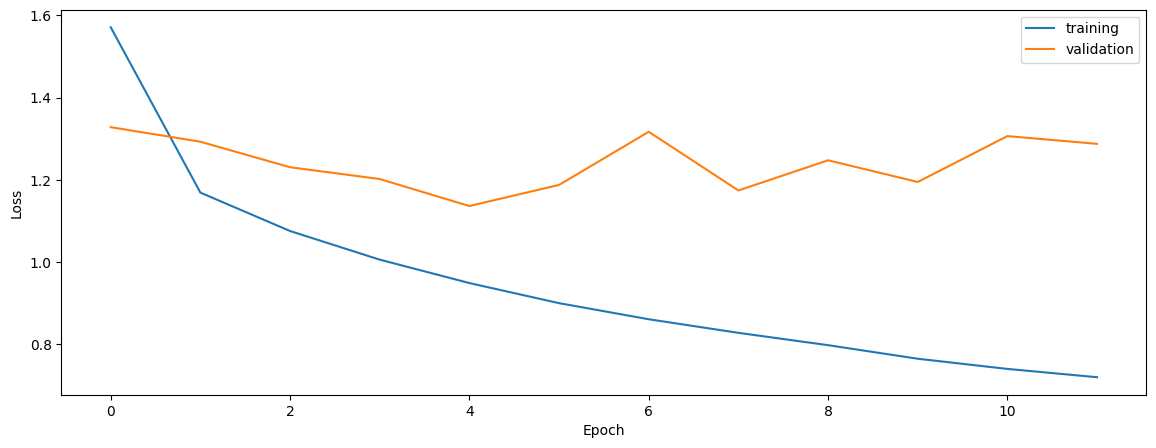

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6335038548783452
0.538170899537095
0.5810472580304311


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5710795361416161
0.5390018996359032
0.5410182119205298


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5583953561708004
0.5342401758724924
0.5342698738762618


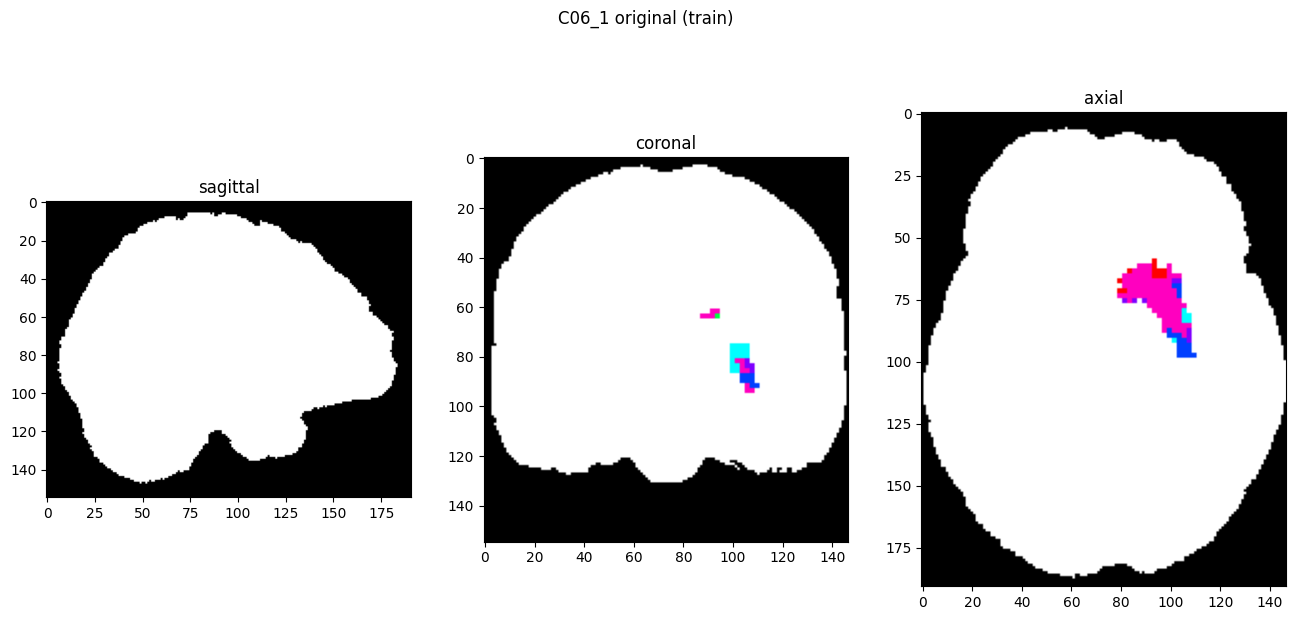

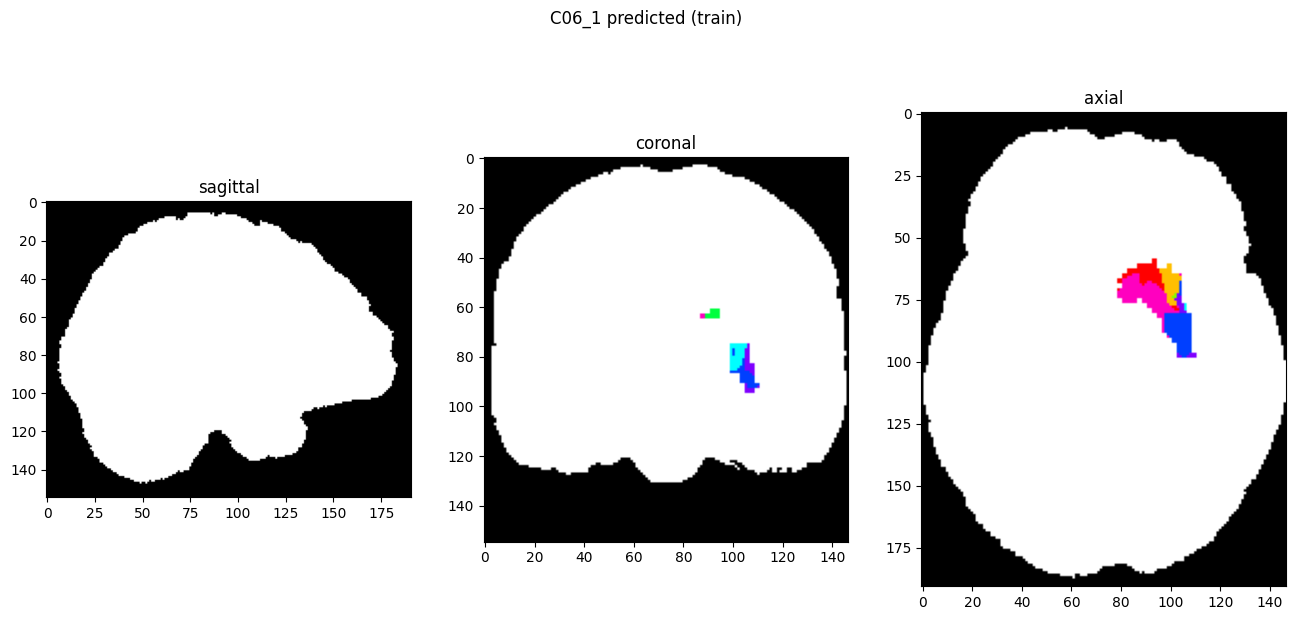

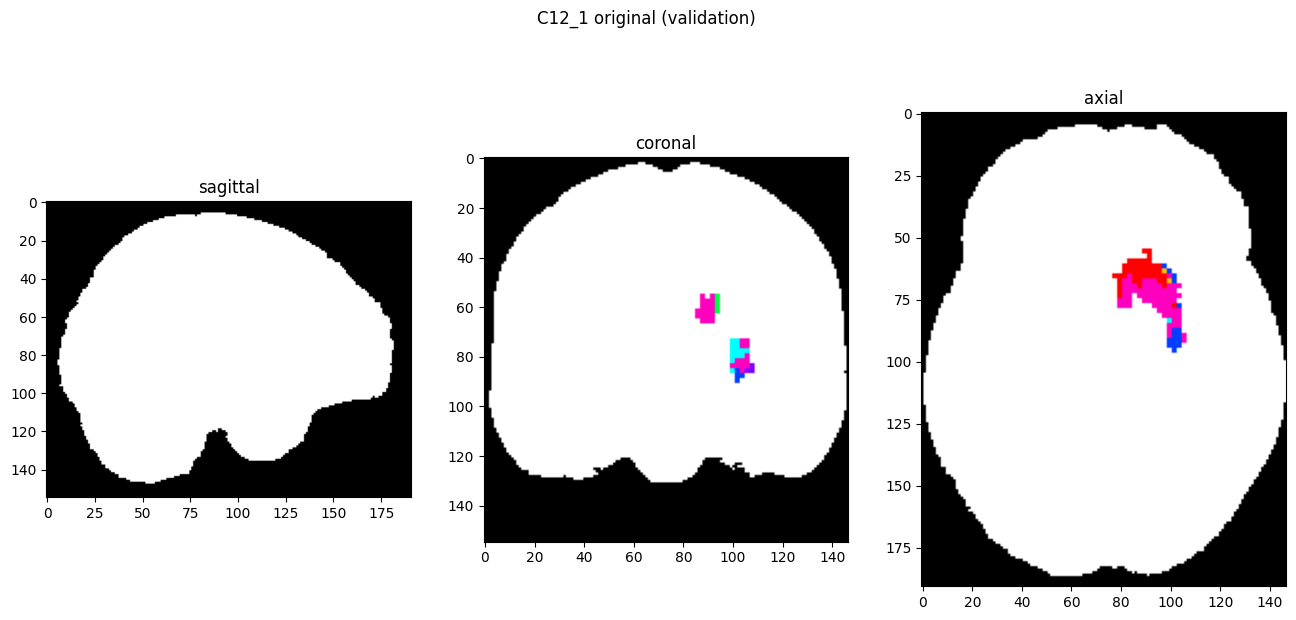

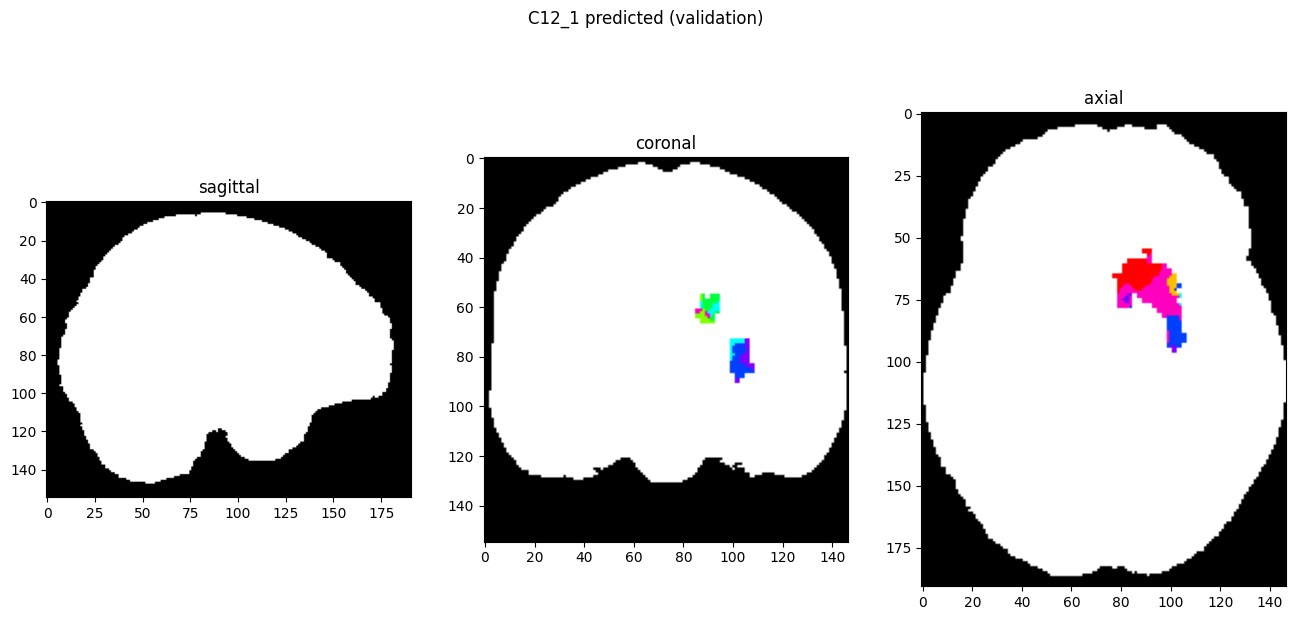

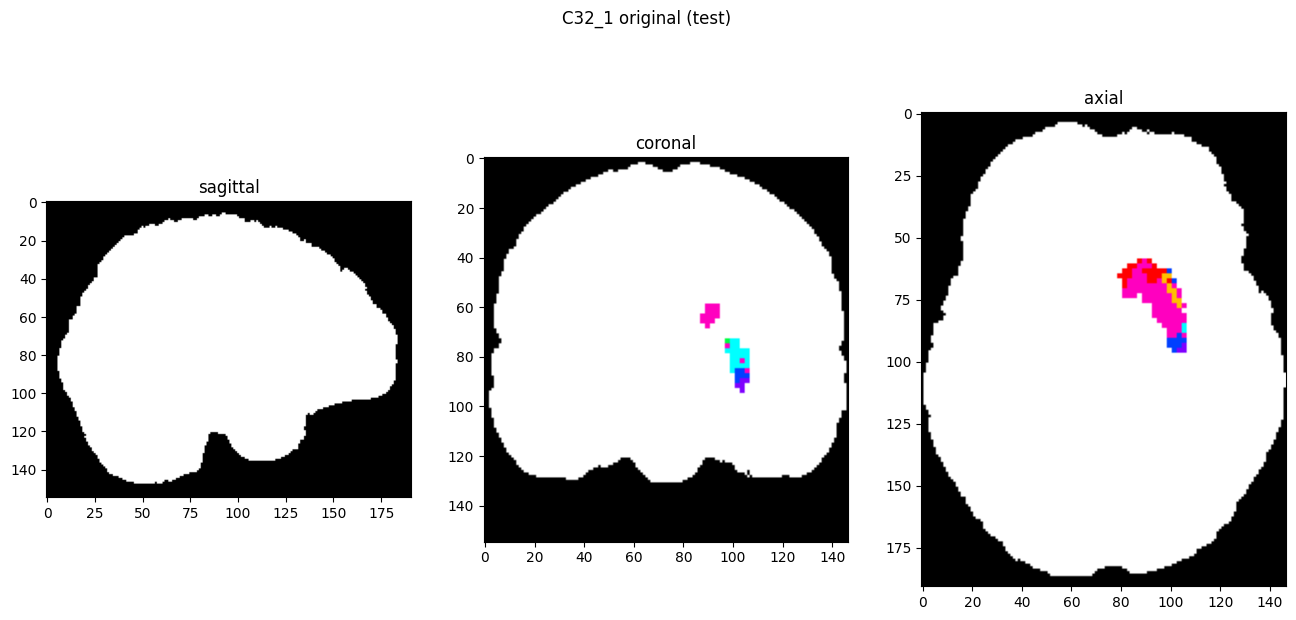

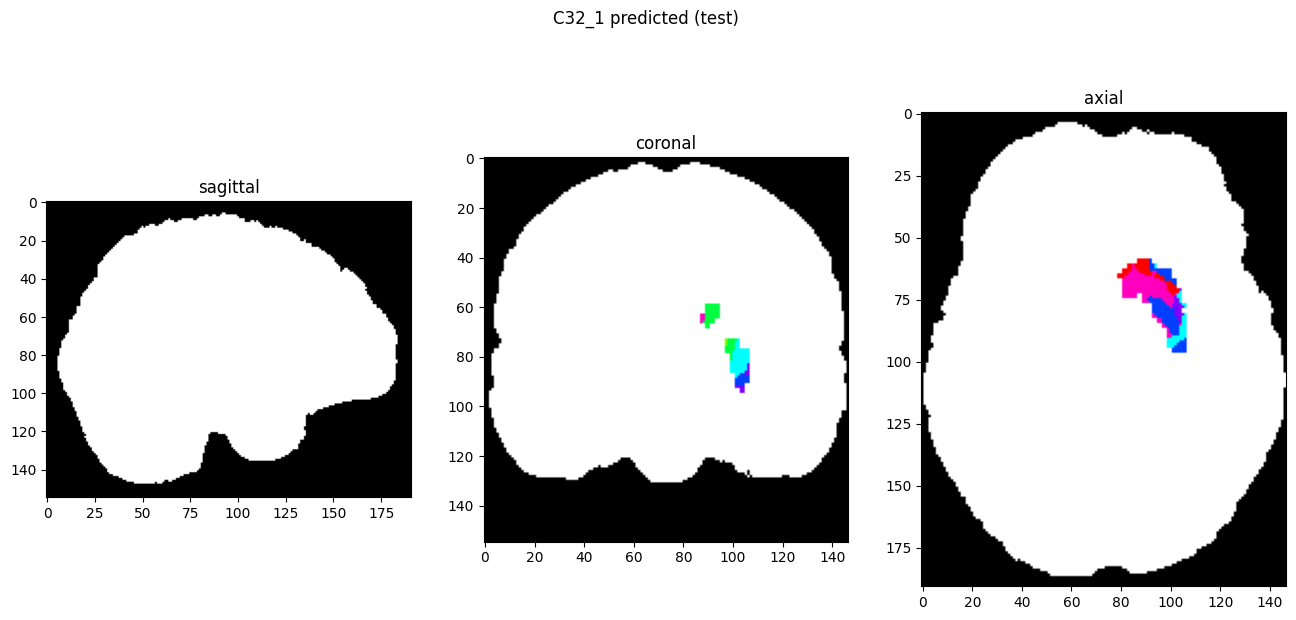

In [10]:
showResults(model, gen, threshold=0)